# Evaluate
https://docs.opencv.org/3.4.1/d1/d89/tutorial_py_orb.html

In [1]:
# init prerequisites
%reload_ext autoreload
%autoreload 2
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os, re, math, time, random, yaml
from pprint import pprint

import tensorflow as tf
from tensorflow import keras

import util
from util import print_warn, horline

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

print("OpenCV {}".format(cv.__version__))
print("Numpy {}".format(np.__version__))
print("Tensorflow {}".format(tf.__version__))

OpenCV 3.4.1
Numpy 1.16.2
Tensorflow 1.13.1


In [2]:
config_modelname="sigmoid-190509"
#config_modelname="tanh-190509"
#config_modelname="relu-190509"

config = dict(
    inputfolder="./input/classes_r3",
    outputfolder="./output/ml",
    
    handle_model_missmatch=False,
    model="./output/{}.h5".format(config_modelname),
    model_map="./output/{}.map".format(config_modelname),
    class_ignore={ # if input data has less labels, tell me which classes can be ignored
        9: [10],  # predicted 10 is also fine for labeled 9
        11: [10], # predicted 10 is also fine for labeled 11
        6: [7],
        8: [7],
        3: [4],
        5: [4],
    }
)
pprint(config)

os.makedirs(config["outputfolder"], exist_ok=True)

{'class_ignore': {3: [4], 5: [4], 6: [7], 8: [7], 9: [10], 11: [10]},
 'handle_model_missmatch': False,
 'inputfolder': './input/classes_r3',
 'model': './output/sigmoid-190509.h5',
 'model_map': './output/sigmoid-190509.map',
 'outputfolder': './output/ml'}


In [3]:
gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
keras.backend.set_session(sess)

print("loading model")
model = keras.models.load_model(config["model"])
model.summary()

import yaml
with open(config["model_map"], 'r') as f:
    model_labels = yaml.load(f, Loader=yaml.FullLoader)
pprint(model_labels)

print("done.")

loading model
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               2560256   
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8

In [4]:
# output helper
def result_to_color(result, index, predicted, labeled):
    if config["handle_model_missmatch"] and labeled in config["class_ignore"] and index in config["class_ignore"][labeled]:
        # green
        color = (32,(0,255,0))
    elif labeled == index:
        # green
        color = (32,(0,255,0))
    elif labeled > len(result):
        # image class was not in training data
        # magenta
        color = (35,(64,64,64))
    else:
        if result[index] > 1e-4:
            if index == predicted:
                # red
                color = (31,(0,0,255))
            else:
                # yellow
                color = (33,(0,255,255))
        else:
            # black
            color = (30,(128,0,0))
    return color

def pprint_result(result, label=None, img=None, count_hit=None, count_miss=None):
    max = np.argmax(result)
    
    put = result[0]
    color = result_to_color(result, 0, max, label)
    str = "[\x1b[{}m{:.4f}".format(color[0], put)
    if img is not None: 
        width = (img.shape[1] - 20) / len(result)
        cv.putText(img, "{:.3f}".format(put), (10,20), font, 0.7, color[1], 2, cv.LINE_AA)

    for j in range(1, len(result)):
        put = result[j]
        color = result_to_color(result, j, max, label)
        str += " \x1b[{}m{:.4f}".format(color[0], put)
        if img is not None: 
            cv.putText(img, "{:.3f}".format(put), (int(10+width*j),20), font, 0.7, color[1], 2, cv.LINE_AA)
    
    if label in label_name:
        str += "\x1b[0m] {} ({}<>{})".format(label_name[label][1], label, max)
    else:
        str += "\x1b[0m] unknown ({}<>{})".format(label, max)
    print(str)
    return str

In [5]:
# collect input files
paths, labels, label_name = util.recursive_collect(config["inputfolder"], model_labels=model_labels)
input_images = []
prev = None

pprint(label_name)

# sort data by image index
input_data = list(zip(paths, labels))
input_data = sorted(input_data, key = lambda x: x[0].split("\\")[-1])
paths, labels = zip(*input_data)

font = cv.FONT_HERSHEY_SIMPLEX

# for evaluation of performance
confusion_labels = list()
confusion_predictions = list()
prediction_errors = list()
count_hit = 0
count_miss = 0

# speedrun
wait_normal = 1
wait_error = 1
wait_on_error = True

cv.destroyAllWindows()
out = None
for i, path, label in zip(range(len(paths)), paths, labels):
    rate = count_hit / (count_hit + count_miss) if (count_hit + count_miss) > 0 else 1.0
    print("{} {:.3f} {}, {}".format(i, rate, path, label))
    start_time = time.perf_counter()

    # read input image
    img = cv.imread(path, cv.IMREAD_GRAYSCALE)
    #img = cv.medianBlur(img, 29)

    mean, dev = cv.meanStdDev(img)
    img_small = cv.resize((img - mean)/dev, (100,100))
    img_small = np.expand_dims(img_small, axis=2)
    img_small = np.expand_dims(img_small, axis=0)
    predictions = model.predict(img_small)
    predicted = np.argmax(predictions)
    confusion_labels.append(label)
    confusion_predictions.append(predicted)
    wait = wait_normal
    
    # convert to colored image for drawing on image
    img = cv.cvtColor(img, cv.COLOR_GRAY2RGB)
    result_str = pprint_result(predictions[0], label, img)
    
    # put information about predicted and labeled class into image
    is_fine = label in config["class_ignore"] and predicted in config["class_ignore"][label]
    if predicted != label and not is_fine:
        cv.putText(img, label_name[np.argmax(predictions)][1], (10,img.shape[0] - 20), font, 0.8, (0,0,255), 2, cv.LINE_AA)
        cv.putText(img, label_name[label][1], (int(img.shape[1]/2 + 10),img.shape[0] - 20), font, 0.8, (0,255,0), 2, cv.LINE_AA)
        prediction_errors.append((path, label, predicted))
        if wait_on_error: wait = wait_error
        count_miss += 1
    else:
        cv.putText(img, label_name[np.argmax(predictions)][1], (10,img.shape[0] - 20), font, 0.8, (0,0,0), 2, cv.LINE_AA)
        count_hit += 1
    
    if out is None:
        outh,outw,_ = img.shape
        out = cv.VideoWriter(os.path.join(config["outputfolder"], "{}.avi".format(config_modelname)), cv.VideoWriter_fourcc(*'MJPG'), 10, (outw,outh))
    out.write(img)
    
    # show images and wait
    cv.imshow('result', img); plt.show()
    k = cv.waitKey(wait) & 0xff
    if k == 27:
        if out is not None:
            out.release()
        break
    elif k == ord('s'):
        if not os.path.isdir(config["outputfolder"]):
            os.mkdir(config["outputfolder"])
        cv.imwrite(os.path.join(config["outputfolder"], os.path.basename(path)), img)


cv.destroyAllWindows()

{0: (129, '1_home'),
 1: (128, '2.1_moving'),
 2: (117, '2.2_moving_wafer'),
 3: (188, '3.1_cassette_location_empty'),
 4: (198, '3.2_cassette_location_unknown'),
 5: (163, '3.3_cassette_location_wafer'),
 6: (399, '4.1_processchamber_empty'),
 7: (206, '4.2_processchamber_unknown'),
 8: (141, '4.3_processchamber_wafer'),
 9: (106, '5.1_cooling_station_wafer'),
 10: (149, '5.2_cooling_station_unknown'),
 11: (170, '5.3_cooling_station_empty')}
0 1.000 ./input/classes_r3\1_home\gray_88201.0.png, 0
[0.9953 0.0000 0.0001 0.0009 0.0006 0.0005 0.0002 0.0000 0.0000 0.0002 0.0023 0.0000] 1_home (0<>0)
1 1.000 ./input/classes_r3\1_home\gray_88202.0.png, 0
[0.9953 0.0000 0.0001 0.0009 0.0006 0.0005 0.0002 0.0000 0.0000 0.0002 0.0023 0.0000] 1_home (0<>0)
2 1.000 ./input/classes_r3\1_home\gray_88203.0.png, 0
[0.9953 0.0000 0.0001 0.0009 0.0006 0.0005 0.0002 0.0000 0.0000 0.0002 0.0023 0.0000] 1_home (0<>0)
3 1.000 ./input/classes_r3\1_home\gray_88204.0.png, 0
[0.9953 0.0000 0.0001 0.0009 0.0006 

[0.9953 0.0000 0.0001 0.0009 0.0006 0.0005 0.0002 0.0000 0.0000 0.0002 0.0023 0.0000] 1_home (0<>0)
39 1.000 ./input/classes_r3\1_home\gray_88240.0.png, 0
[0.9953 0.0000 0.0001 0.0009 0.0006 0.0005 0.0002 0.0000 0.0000 0.0002 0.0023 0.0000] 1_home (0<>0)
40 1.000 ./input/classes_r3\1_home\gray_88241.0.png, 0
[0.9953 0.0000 0.0001 0.0009 0.0006 0.0005 0.0002 0.0000 0.0000 0.0002 0.0023 0.0000] 1_home (0<>0)
41 1.000 ./input/classes_r3\1_home\gray_88242.0.png, 0
[0.9953 0.0000 0.0001 0.0009 0.0006 0.0005 0.0002 0.0000 0.0000 0.0002 0.0023 0.0000] 1_home (0<>0)
42 1.000 ./input/classes_r3\1_home\gray_88243.0.png, 0
[0.9953 0.0000 0.0001 0.0009 0.0006 0.0005 0.0002 0.0000 0.0000 0.0002 0.0023 0.0000] 1_home (0<>0)
43 1.000 ./input/classes_r3\1_home\gray_88244.0.png, 0
[0.9953 0.0000 0.0001 0.0009 0.0006 0.0005 0.0002 0.0000 0.0000 0.0002 0.0023 0.0000] 1_home (0<>0)
44 1.000 ./input/classes_r3\1_home\gray_88245.0.png, 0
[0.9953 0.0000 0.0001 0.0009 0.0006 0.0005 0.0002 0.0000 0.0000 0.0002

[0.9953 0.0000 0.0001 0.0009 0.0006 0.0005 0.0002 0.0000 0.0000 0.0002 0.0023 0.0000] 1_home (0<>0)
78 1.000 ./input/classes_r3\1_home\gray_88279.0.png, 0
[0.9953 0.0000 0.0001 0.0009 0.0006 0.0005 0.0002 0.0000 0.0000 0.0002 0.0023 0.0000] 1_home (0<>0)
79 1.000 ./input/classes_r3\1_home\gray_88280.0.png, 0
[0.9953 0.0000 0.0001 0.0009 0.0006 0.0005 0.0002 0.0000 0.0000 0.0002 0.0023 0.0000] 1_home (0<>0)
80 1.000 ./input/classes_r3\1_home\gray_88281.0.png, 0
[0.9953 0.0000 0.0001 0.0009 0.0006 0.0005 0.0002 0.0000 0.0000 0.0002 0.0023 0.0000] 1_home (0<>0)
81 1.000 ./input/classes_r3\1_home\gray_88282.0.png, 0
[0.9953 0.0000 0.0001 0.0009 0.0006 0.0005 0.0002 0.0000 0.0000 0.0002 0.0023 0.0000] 1_home (0<>0)
82 1.000 ./input/classes_r3\1_home\gray_88283.0.png, 0
[0.9953 0.0000 0.0001 0.0009 0.0006 0.0005 0.0002 0.0000 0.0000 0.0002 0.0023 0.0000] 1_home (0<>0)
83 1.000 ./input/classes_r3\1_home\gray_88284.0.png, 0
[0.9953 0.0000 0.0001 0.0009 0.0006 0.0005 0.0002 0.0000 0.0000 0.0002

[0.9953 0.0000 0.0001 0.0009 0.0006 0.0005 0.0002 0.0000 0.0000 0.0002 0.0023 0.0000] 1_home (0<>0)
117 1.000 ./input/classes_r3\1_home\gray_88318.0.png, 0
[0.9953 0.0000 0.0001 0.0009 0.0006 0.0005 0.0002 0.0000 0.0000 0.0002 0.0023 0.0000] 1_home (0<>0)
118 1.000 ./input/classes_r3\1_home\gray_88319.0.png, 0
[0.9953 0.0000 0.0001 0.0009 0.0006 0.0005 0.0002 0.0000 0.0000 0.0002 0.0023 0.0000] 1_home (0<>0)
119 1.000 ./input/classes_r3\1_home\gray_88320.0.png, 0
[0.9953 0.0000 0.0001 0.0009 0.0006 0.0005 0.0002 0.0000 0.0000 0.0002 0.0023 0.0000] 1_home (0<>0)
120 1.000 ./input/classes_r3\1_home\gray_88321.0.png, 0
[0.9924 0.0000 0.0002 0.0012 0.0020 0.0012 0.0002 0.0000 0.0000 0.0001 0.0027 0.0000] 1_home (0<>0)
121 1.000 ./input/classes_r3\1_home\gray_88322.0.png, 0
[0.8703 0.0000 0.0021 0.0111 0.0832 0.0225 0.0007 0.0000 0.0001 0.0002 0.0096 0.0001] 1_home (0<>0)
122 1.000 ./input/classes_r3\1_home\gray_88323.0.png, 0
[0.8702 0.0000 0.0017 0.0125 0.0864 0.0183 0.0007 0.0000 0.0002 

154 0.974 ./input/classes_r3\3.2_cassette_location_unknown\gray_88355.0.png, 4
[0.0013 0.0000 0.0001 0.0203 0.9515 0.0257 0.0001 0.0000 0.0007 0.0000 0.0002 0.0000] 3.2_cassette_location_unknown (4<>4)
155 0.974 ./input/classes_r3\3.2_cassette_location_unknown\gray_88356.0.png, 4
[0.0013 0.0000 0.0001 0.0203 0.9516 0.0256 0.0001 0.0000 0.0007 0.0000 0.0002 0.0000] 3.2_cassette_location_unknown (4<>4)
156 0.974 ./input/classes_r3\3.3_cassette_location_wafer\gray_88357.0.png, 5
[0.0003 0.0000 0.0065 0.0022 0.0183 0.9715 0.0000 0.0000 0.0008 0.0000 0.0003 0.0000] 3.3_cassette_location_wafer (5<>5)
157 0.975 ./input/classes_r3\3.3_cassette_location_wafer\gray_88358.0.png, 5
[0.0002 0.0000 0.0048 0.0015 0.0117 0.9810 0.0000 0.0000 0.0005 0.0000 0.0002 0.0000] 3.3_cassette_location_wafer (5<>5)
158 0.975 ./input/classes_r3\3.3_cassette_location_wafer\gray_88359.0.png, 5
[0.0002 0.0000 0.0049 0.0014 0.0114 0.9814 0.0000 0.0000 0.0005 0.0000 0.0002 0.0000] 3.3_cassette_location_wafer (5<>5)
15

[0.0000 0.0014 0.0000 0.0000 0.0000 0.0000 0.0032 0.9906 0.0001 0.0007 0.0023 0.0017] 4.2_processchamber_unknown (7<>7)
187 0.973 ./input/classes_r3\4.1_processchamber_empty\gray_88388.0.png, 6
[0.0001 0.0001 0.0000 0.0011 0.0000 0.0000 0.9972 0.0009 0.0000 0.0000 0.0005 0.0000] 4.1_processchamber_empty (6<>6)
188 0.973 ./input/classes_r3\4.1_processchamber_empty\gray_88389.0.png, 6
[0.0001 0.0001 0.0000 0.0014 0.0000 0.0000 0.9973 0.0005 0.0000 0.0000 0.0005 0.0000] 4.1_processchamber_empty (6<>6)
189 0.974 ./input/classes_r3\4.1_processchamber_empty\gray_88390.0.png, 6
[0.0001 0.0001 0.0000 0.0015 0.0000 0.0000 0.9973 0.0005 0.0000 0.0000 0.0005 0.0000] 4.1_processchamber_empty (6<>6)
190 0.974 ./input/classes_r3\4.1_processchamber_empty\gray_88391.0.png, 6
[0.0001 0.0001 0.0000 0.0015 0.0000 0.0000 0.9973 0.0005 0.0000 0.0000 0.0005 0.0000] 4.1_processchamber_empty (6<>6)
191 0.974 ./input/classes_r3\4.1_processchamber_empty\gray_88392.0.png, 6
[0.0001 0.0001 0.0000 0.0014 0.0000 0.

[0.0001 0.0002 0.0000 0.0041 0.0001 0.0000 0.9941 0.0006 0.0000 0.0000 0.0006 0.0000] 4.1_processchamber_empty (6<>6)
219 0.977 ./input/classes_r3\4.1_processchamber_empty\gray_88931.0.png, 6
[0.0001 0.0002 0.0000 0.0031 0.0001 0.0000 0.9952 0.0006 0.0000 0.0000 0.0006 0.0000] 4.1_processchamber_empty (6<>6)
220 0.977 ./input/classes_r3\4.1_processchamber_empty\gray_88932.0.png, 6
[0.0001 0.0002 0.0000 0.0031 0.0001 0.0000 0.9953 0.0006 0.0000 0.0000 0.0006 0.0000] 4.1_processchamber_empty (6<>6)
221 0.977 ./input/classes_r3\4.1_processchamber_empty\gray_88938.0.png, 6
[0.0001 0.0002 0.0000 0.0040 0.0001 0.0000 0.9942 0.0006 0.0000 0.0000 0.0006 0.0000] 4.1_processchamber_empty (6<>6)
222 0.977 ./input/classes_r3\4.1_processchamber_empty\gray_88939.0.png, 6
[0.0001 0.0001 0.0000 0.0012 0.0000 0.0000 0.9977 0.0004 0.0000 0.0000 0.0005 0.0000] 4.1_processchamber_empty (6<>6)
223 0.978 ./input/classes_r3\4.1_processchamber_empty\gray_88940.0.png, 6
[0.0001 0.0000 0.0000 0.0008 0.0000 0.00

251 0.976 ./input/classes_r3\5.1_cooling_station_wafer\gray_89022.0.png, 9
[0.0063 0.0000 0.9197 0.0000 0.0000 0.0035 0.0000 0.0009 0.0059 0.0538 0.0093 0.0006] 5.1_cooling_station_wafer (9<>2)
252 0.972 ./input/classes_r3\5.1_cooling_station_wafer\gray_89023.0.png, 9
[0.0238 0.0000 0.5492 0.0001 0.0000 0.0019 0.0001 0.0018 0.0039 0.3924 0.0222 0.0045] 5.1_cooling_station_wafer (9<>2)
253 0.968 ./input/classes_r3\5.1_cooling_station_wafer\gray_89024.0.png, 9
[0.0002 0.0000 0.0033 0.0000 0.0000 0.0000 0.0001 0.0011 0.0002 0.9837 0.0045 0.0068] 5.1_cooling_station_wafer (9<>9)
254 0.969 ./input/classes_r3\5.1_cooling_station_wafer\gray_89025.0.png, 9
[0.0001 0.0000 0.0012 0.0000 0.0000 0.0000 0.0001 0.0012 0.0002 0.9885 0.0031 0.0056] 5.1_cooling_station_wafer (9<>9)
255 0.969 ./input/classes_r3\5.1_cooling_station_wafer\gray_89026.0.png, 9
[0.0001 0.0000 0.0012 0.0000 0.0000 0.0000 0.0001 0.0013 0.0002 0.9884 0.0031 0.0057] 5.1_cooling_station_wafer (9<>9)
256 0.969 ./input/classes_r3\5

[0.0005 0.0038 0.0000 0.9735 0.0182 0.0007 0.0031 0.0000 0.0000 0.0000 0.0001 0.0001] 3.1_cassette_location_empty (3<>3)
284 0.972 ./input/classes_r3\3.1_cassette_location_empty\gray_89055.0.png, 3
[0.0005 0.0072 0.0000 0.9707 0.0161 0.0008 0.0044 0.0001 0.0001 0.0000 0.0001 0.0002] 3.1_cassette_location_empty (3<>3)
285 0.972 ./input/classes_r3\3.1_cassette_location_empty\gray_89056.0.png, 3
[0.0005 0.0051 0.0000 0.9729 0.0168 0.0007 0.0036 0.0000 0.0001 0.0000 0.0001 0.0001] 3.1_cassette_location_empty (3<>3)
286 0.972 ./input/classes_r3\3.1_cassette_location_empty\gray_89057.0.png, 3
[0.0005 0.0054 0.0000 0.9727 0.0167 0.0007 0.0038 0.0000 0.0001 0.0000 0.0001 0.0001] 3.1_cassette_location_empty (3<>3)
287 0.972 ./input/classes_r3\3.1_cassette_location_empty\gray_89058.0.png, 3
[0.0005 0.0048 0.0000 0.9731 0.0170 0.0007 0.0035 0.0000 0.0001 0.0000 0.0001 0.0001] 3.1_cassette_location_empty (3<>3)
288 0.972 ./input/classes_r3\3.1_cassette_location_empty\gray_89059.0.png, 3
[0.0005 0.

316 0.975 ./input/classes_r3\4.3_processchamber_wafer\gray_89087.0.png, 8
[0.0000 0.0007 0.0055 0.0001 0.0008 0.0010 0.0000 0.0009 0.9886 0.0005 0.0001 0.0018] 4.3_processchamber_wafer (8<>8)
317 0.975 ./input/classes_r3\4.3_processchamber_wafer\gray_89088.0.png, 8
[0.0000 0.0007 0.0055 0.0001 0.0008 0.0010 0.0000 0.0009 0.9886 0.0005 0.0001 0.0018] 4.3_processchamber_wafer (8<>8)
318 0.975 ./input/classes_r3\4.3_processchamber_wafer\gray_89089.0.png, 8
[0.0000 0.0007 0.0055 0.0001 0.0008 0.0010 0.0000 0.0009 0.9886 0.0005 0.0001 0.0018] 4.3_processchamber_wafer (8<>8)
319 0.975 ./input/classes_r3\4.3_processchamber_wafer\gray_89090.0.png, 8
[0.0000 0.0007 0.0055 0.0001 0.0008 0.0010 0.0000 0.0009 0.9886 0.0005 0.0001 0.0018] 4.3_processchamber_wafer (8<>8)
320 0.975 ./input/classes_r3\4.3_processchamber_wafer\gray_89091.0.png, 8
[0.0000 0.0007 0.0058 0.0001 0.0007 0.0009 0.0000 0.0009 0.9882 0.0005 0.0001 0.0021] 4.3_processchamber_wafer (8<>8)
321 0.975 ./input/classes_r3\4.3_process

[0.0001 0.0000 0.0000 0.0007 0.0000 0.0000 0.9983 0.0003 0.0000 0.0000 0.0004 0.0000] 4.1_processchamber_empty (6<>6)
349 0.977 ./input/classes_r3\4.1_processchamber_empty\gray_89120.0.png, 6
[0.0001 0.0000 0.0000 0.0007 0.0000 0.0000 0.9984 0.0003 0.0000 0.0000 0.0004 0.0000] 4.1_processchamber_empty (6<>6)
350 0.977 ./input/classes_r3\4.1_processchamber_empty\gray_89272.0.png, 6
[0.0001 0.0000 0.0000 0.0007 0.0000 0.0000 0.9984 0.0003 0.0000 0.0000 0.0004 0.0000] 4.1_processchamber_empty (6<>6)
351 0.977 ./input/classes_r3\4.1_processchamber_empty\gray_89273.0.png, 6
[0.0001 0.0000 0.0000 0.0007 0.0000 0.0000 0.9983 0.0003 0.0000 0.0000 0.0004 0.0000] 4.1_processchamber_empty (6<>6)
352 0.977 ./input/classes_r3\4.1_processchamber_empty\gray_89274.0.png, 6
[0.0001 0.0000 0.0000 0.0007 0.0000 0.0000 0.9984 0.0003 0.0000 0.0000 0.0004 0.0000] 4.1_processchamber_empty (6<>6)
353 0.977 ./input/classes_r3\4.1_processchamber_empty\gray_89275.0.png, 6
[0.0001 0.0000 0.0000 0.0007 0.0000 0.00

381 0.974 ./input/classes_r3\5.1_cooling_station_wafer\gray_89379.0.png, 9
[0.0001 0.0000 0.0012 0.0000 0.0000 0.0000 0.0000 0.0012 0.0002 0.9886 0.0031 0.0055] 5.1_cooling_station_wafer (9<>9)
382 0.974 ./input/classes_r3\5.1_cooling_station_wafer\gray_89380.0.png, 9
[0.0159 0.0000 0.2667 0.0001 0.0000 0.0011 0.0001 0.0022 0.0029 0.6817 0.0220 0.0072] 5.1_cooling_station_wafer (9<>9)
383 0.974 ./input/classes_r3\2.2_moving_wafer\gray_89381.0.png, 2
[0.0001 0.0000 0.9805 0.0001 0.0001 0.0085 0.0000 0.0000 0.0076 0.0015 0.0010 0.0006] 2.2_moving_wafer (2<>2)
384 0.974 ./input/classes_r3\2.2_moving_wafer\gray_89382.0.png, 2
[0.0001 0.0000 0.9804 0.0001 0.0001 0.0082 0.0000 0.0001 0.0076 0.0017 0.0011 0.0006] 2.2_moving_wafer (2<>2)
385 0.974 ./input/classes_r3\2.2_moving_wafer\gray_89383.0.png, 2
[0.0001 0.0000 0.9790 0.0001 0.0002 0.0100 0.0000 0.0000 0.0081 0.0011 0.0008 0.0006] 2.2_moving_wafer (2<>2)
386 0.974 ./input/classes_r3\3.3_cassette_location_wafer\gray_89384.0.png, 5
[0.0003

[0.0005 0.0065 0.0000 0.9701 0.0181 0.0008 0.0036 0.0001 0.0001 0.0000 0.0001 0.0001] 3.1_cassette_location_empty (3<>3)
414 0.976 ./input/classes_r3\3.1_cassette_location_empty\gray_89412.0.png, 3
[0.0005 0.0067 0.0000 0.9701 0.0179 0.0008 0.0037 0.0001 0.0001 0.0000 0.0001 0.0002] 3.1_cassette_location_empty (3<>3)
415 0.976 ./input/classes_r3\3.1_cassette_location_empty\gray_89413.0.png, 3
[0.0005 0.0067 0.0000 0.9700 0.0180 0.0008 0.0036 0.0001 0.0001 0.0000 0.0001 0.0001] 3.1_cassette_location_empty (3<>3)
416 0.976 ./input/classes_r3\3.1_cassette_location_empty\gray_89414.0.png, 3
[0.0005 0.0069 0.0000 0.9703 0.0171 0.0008 0.0041 0.0001 0.0001 0.0000 0.0001 0.0002] 3.1_cassette_location_empty (3<>3)
417 0.976 ./input/classes_r3\2.1_moving\gray_89415.0.png, 1
[0.0004 0.1056 0.0000 0.8628 0.0127 0.0013 0.0139 0.0007 0.0005 0.0000 0.0003 0.0018] 2.1_moving (1<>3)
418 0.974 ./input/classes_r3\2.1_moving\gray_89416.0.png, 1
[0.0000 0.9132 0.0000 0.0688 0.0005 0.0003 0.0030 0.0060 0.00

446 0.973 ./input/classes_r3\4.1_processchamber_empty\gray_89645.0.png, 6
[0.0001 0.0002 0.0000 0.0032 0.0001 0.0000 0.9952 0.0006 0.0000 0.0000 0.0006 0.0000] 4.1_processchamber_empty (6<>6)
447 0.973 ./input/classes_r3\4.1_processchamber_empty\gray_89646.0.png, 6
[0.0001 0.0002 0.0000 0.0041 0.0001 0.0000 0.9941 0.0006 0.0000 0.0000 0.0006 0.0000] 4.1_processchamber_empty (6<>6)
448 0.973 ./input/classes_r3\4.1_processchamber_empty\gray_89707.0.png, 6
[0.0001 0.0000 0.0000 0.0008 0.0000 0.0000 0.9982 0.0003 0.0000 0.0000 0.0004 0.0000] 4.1_processchamber_empty (6<>6)
449 0.973 ./input/classes_r3\4.1_processchamber_empty\gray_89708.0.png, 6
[0.0001 0.0000 0.0000 0.0009 0.0000 0.0000 0.9981 0.0004 0.0000 0.0000 0.0004 0.0000] 4.1_processchamber_empty (6<>6)
450 0.973 ./input/classes_r3\4.1_processchamber_empty\gray_89709.0.png, 6
[0.0001 0.0001 0.0000 0.0013 0.0000 0.0000 0.9976 0.0004 0.0000 0.0000 0.0005 0.0000] 4.1_processchamber_empty (6<>6)
451 0.973 ./input/classes_r3\4.1_process

[0.0024 0.0000 0.0009 0.0000 0.0000 0.0001 0.0023 0.0019 0.0000 0.0084 0.9835 0.0006] 5.2_cooling_station_unknown (10<>10)
479 0.971 ./input/classes_r3\5.2_cooling_station_unknown\gray_89743.0.png, 10
[0.0024 0.0000 0.0009 0.0000 0.0000 0.0001 0.0023 0.0019 0.0000 0.0085 0.9833 0.0006] 5.2_cooling_station_unknown (10<>10)
480 0.971 ./input/classes_r3\5.2_cooling_station_unknown\gray_89744.0.png, 10
[0.0026 0.0000 0.0010 0.0000 0.0000 0.0001 0.0023 0.0020 0.0000 0.0104 0.9809 0.0007] 5.2_cooling_station_unknown (10<>10)
481 0.971 ./input/classes_r3\5.2_cooling_station_unknown\gray_89745.0.png, 10
[0.0025 0.0000 0.0010 0.0000 0.0000 0.0001 0.0022 0.0019 0.0000 0.0093 0.9824 0.0006] 5.2_cooling_station_unknown (10<>10)
482 0.971 ./input/classes_r3\5.3_cooling_station_empty\gray_89746.0.png, 11
[0.0000 0.0043 0.0003 0.0000 0.0000 0.0000 0.0000 0.0033 0.0027 0.0032 0.0002 0.9859] 5.3_cooling_station_empty (11<>11)
483 0.971 ./input/classes_r3\5.3_cooling_station_empty\gray_89747.0.png, 11
[

511 0.973 ./input/classes_r3\3.2_cassette_location_unknown\gray_89775.0.png, 4
[0.0007 0.0000 0.0000 0.0155 0.9756 0.0076 0.0001 0.0000 0.0004 0.0000 0.0001 0.0000] 3.2_cassette_location_unknown (4<>4)
512 0.973 ./input/classes_r3\3.2_cassette_location_unknown\gray_89776.0.png, 4
[0.0007 0.0000 0.0000 0.0155 0.9756 0.0076 0.0001 0.0000 0.0004 0.0000 0.0001 0.0000] 3.2_cassette_location_unknown (4<>4)
513 0.973 ./input/classes_r3\3.2_cassette_location_unknown\gray_89777.0.png, 4
[0.0007 0.0000 0.0000 0.0155 0.9756 0.0076 0.0001 0.0000 0.0004 0.0000 0.0001 0.0000] 3.2_cassette_location_unknown (4<>4)
514 0.973 ./input/classes_r3\3.2_cassette_location_unknown\gray_89778.0.png, 4
[0.0007 0.0000 0.0000 0.0155 0.9756 0.0076 0.0001 0.0000 0.0004 0.0000 0.0001 0.0000] 3.2_cassette_location_unknown (4<>4)
515 0.973 ./input/classes_r3\3.2_cassette_location_unknown\gray_89779.0.png, 4
[0.0007 0.0000 0.0000 0.0155 0.9756 0.0076 0.0001 0.0000 0.0004 0.0000 0.0001 0.0000] 3.2_cassette_location_unkno

[0.0000 0.0011 0.0000 0.0000 0.0000 0.0000 0.0032 0.9913 0.0001 0.0007 0.0022 0.0014] 4.2_processchamber_unknown (7<>7)
544 0.972 ./input/classes_r3\4.2_processchamber_unknown\gray_89808.0.png, 7
[0.0000 0.0011 0.0000 0.0000 0.0000 0.0000 0.0032 0.9913 0.0001 0.0007 0.0022 0.0014] 4.2_processchamber_unknown (7<>7)
545 0.972 ./input/classes_r3\4.2_processchamber_unknown\gray_89809.0.png, 7
[0.0000 0.0011 0.0000 0.0000 0.0000 0.0000 0.0032 0.9913 0.0001 0.0007 0.0022 0.0014] 4.2_processchamber_unknown (7<>7)
546 0.973 ./input/classes_r3\4.2_processchamber_unknown\gray_89810.0.png, 7
[0.0000 0.0011 0.0000 0.0000 0.0000 0.0000 0.0032 0.9913 0.0001 0.0007 0.0022 0.0014] 4.2_processchamber_unknown (7<>7)
547 0.973 ./input/classes_r3\4.2_processchamber_unknown\gray_89811.0.png, 7
[0.0000 0.0011 0.0000 0.0000 0.0000 0.0000 0.0032 0.9913 0.0001 0.0007 0.0022 0.0014] 4.2_processchamber_unknown (7<>7)
548 0.973 ./input/classes_r3\4.2_processchamber_unknown\gray_89812.0.png, 7
[0.0000 0.0012 0.000

[0.0001 0.0000 0.0000 0.0008 0.0000 0.0000 0.9983 0.0004 0.0000 0.0000 0.0004 0.0000] 4.1_processchamber_empty (6<>6)
576 0.974 ./input/classes_r3\4.1_processchamber_empty\gray_89992.0.png, 6
[0.0001 0.0000 0.0000 0.0008 0.0000 0.0000 0.9982 0.0004 0.0000 0.0000 0.0004 0.0000] 4.1_processchamber_empty (6<>6)
577 0.974 ./input/classes_r3\4.1_processchamber_empty\gray_89993.0.png, 6
[0.0001 0.0000 0.0000 0.0009 0.0000 0.0000 0.9981 0.0004 0.0000 0.0000 0.0004 0.0000] 4.1_processchamber_empty (6<>6)
578 0.974 ./input/classes_r3\4.1_processchamber_empty\gray_89994.0.png, 6
[0.0001 0.0001 0.0000 0.0009 0.0000 0.0000 0.9980 0.0005 0.0000 0.0000 0.0005 0.0000] 4.1_processchamber_empty (6<>6)
579 0.974 ./input/classes_r3\4.1_processchamber_empty\gray_89995.0.png, 6
[0.0001 0.0000 0.0000 0.0009 0.0000 0.0000 0.9981 0.0004 0.0000 0.0000 0.0004 0.0000] 4.1_processchamber_empty (6<>6)
580 0.974 ./input/classes_r3\4.1_processchamber_empty\gray_89996.0.png, 6
[0.0001 0.0001 0.0000 0.0010 0.0000 0.00

608 0.974 ./input/classes_r3\5.2_cooling_station_unknown\gray_90084.0.png, 10
[0.0023 0.0000 0.0009 0.0000 0.0000 0.0001 0.0023 0.0019 0.0000 0.0084 0.9835 0.0006] 5.2_cooling_station_unknown (10<>10)
609 0.974 ./input/classes_r3\5.2_cooling_station_unknown\gray_90085.0.png, 10
[0.0001 0.0000 0.0013 0.0000 0.0000 0.0000 0.0001 0.0012 0.0002 0.9883 0.0032 0.0056] 5.2_cooling_station_unknown (10<>9)
610 0.972 ./input/classes_r3\5.1_cooling_station_wafer\gray_90086.0.png, 9
[0.0001 0.0000 0.0012 0.0000 0.0000 0.0000 0.0001 0.0012 0.0002 0.9885 0.0031 0.0056] 5.1_cooling_station_wafer (9<>9)
611 0.972 ./input/classes_r3\5.1_cooling_station_wafer\gray_90087.0.png, 9
[0.0001 0.0000 0.0012 0.0000 0.0000 0.0000 0.0001 0.0012 0.0002 0.9885 0.0031 0.0056] 5.1_cooling_station_wafer (9<>9)
612 0.972 ./input/classes_r3\5.1_cooling_station_wafer\gray_90088.0.png, 9
[0.0001 0.0000 0.0012 0.0000 0.0000 0.0000 0.0001 0.0012 0.0002 0.9885 0.0031 0.0056] 5.1_cooling_station_wafer (9<>9)
613 0.972 ./input

[0.0009 0.0000 0.0001 0.0169 0.9709 0.0105 0.0001 0.0000 0.0005 0.0000 0.0001 0.0000] 3.2_cassette_location_unknown (4<>4)
641 0.972 ./input/classes_r3\3.1_cassette_location_empty\gray_90117.0.png, 3
[0.0013 0.0000 0.0001 0.0198 0.9553 0.0226 0.0001 0.0000 0.0006 0.0000 0.0002 0.0000] 3.1_cassette_location_empty (3<>4)
642 0.972 ./input/classes_r3\3.1_cassette_location_empty\gray_90118.0.png, 3
[0.0006 0.0064 0.0000 0.9656 0.0233 0.0010 0.0027 0.0001 0.0001 0.0000 0.0001 0.0001] 3.1_cassette_location_empty (3<>3)
643 0.972 ./input/classes_r3\3.1_cassette_location_empty\gray_90119.0.png, 3
[0.0007 0.0055 0.0000 0.9587 0.0311 0.0011 0.0024 0.0001 0.0001 0.0000 0.0001 0.0001] 3.1_cassette_location_empty (3<>3)
644 0.972 ./input/classes_r3\3.1_cassette_location_empty\gray_90120.0.png, 3
[0.0007 0.0052 0.0000 0.9577 0.0325 0.0012 0.0023 0.0001 0.0001 0.0000 0.0001 0.0001] 3.1_cassette_location_empty (3<>3)
645 0.972 ./input/classes_r3\3.1_cassette_location_empty\gray_90121.0.png, 3
[0.0005 

673 0.972 ./input/classes_r3\4.1_processchamber_empty\gray_90370.0.png, 6
[0.0001 0.0000 0.0000 0.0008 0.0000 0.0000 0.9982 0.0003 0.0000 0.0000 0.0004 0.0000] 4.1_processchamber_empty (6<>6)
674 0.972 ./input/classes_r3\4.1_processchamber_empty\gray_90371.0.png, 6
[0.0001 0.0000 0.0000 0.0008 0.0000 0.0000 0.9982 0.0003 0.0000 0.0000 0.0004 0.0000] 4.1_processchamber_empty (6<>6)
675 0.972 ./input/classes_r3\4.1_processchamber_empty\gray_90372.0.png, 6
[0.0001 0.0000 0.0000 0.0008 0.0000 0.0000 0.9982 0.0003 0.0000 0.0000 0.0004 0.0000] 4.1_processchamber_empty (6<>6)
676 0.972 ./input/classes_r3\4.1_processchamber_empty\gray_90373.0.png, 6
[0.0001 0.0000 0.0000 0.0008 0.0000 0.0000 0.9982 0.0003 0.0000 0.0000 0.0004 0.0000] 4.1_processchamber_empty (6<>6)
677 0.972 ./input/classes_r3\4.1_processchamber_empty\gray_90374.0.png, 6
[0.0001 0.0000 0.0000 0.0008 0.0000 0.0000 0.9982 0.0003 0.0000 0.0000 0.0004 0.0000] 4.1_processchamber_empty (6<>6)
678 0.972 ./input/classes_r3\4.1_process

[0.0000 0.0007 0.0055 0.0001 0.0008 0.0010 0.0000 0.0009 0.9887 0.0005 0.0001 0.0018] 4.3_processchamber_wafer (8<>8)
706 0.973 ./input/classes_r3\4.3_processchamber_wafer\gray_90439.0.png, 8
[0.0000 0.0005 0.0088 0.0001 0.0006 0.0009 0.0000 0.0010 0.9844 0.0007 0.0001 0.0031] 4.3_processchamber_wafer (8<>8)
707 0.973 ./input/classes_r3\2.2_moving_wafer\gray_90440.0.png, 2
[0.0001 0.0000 0.9805 0.0001 0.0001 0.0085 0.0000 0.0000 0.0076 0.0015 0.0010 0.0006] 2.2_moving_wafer (2<>2)
708 0.973 ./input/classes_r3\2.2_moving_wafer\gray_90441.0.png, 2
[0.0001 0.0000 0.9805 0.0001 0.0001 0.0085 0.0000 0.0000 0.0076 0.0015 0.0010 0.0006] 2.2_moving_wafer (2<>2)
709 0.973 ./input/classes_r3\2.2_moving_wafer\gray_90442.0.png, 2
[0.0012 0.0000 0.9716 0.0000 0.0001 0.0049 0.0000 0.0003 0.0060 0.0116 0.0039 0.0004] 2.2_moving_wafer (2<>2)
710 0.973 ./input/classes_r3\5.1_cooling_station_wafer\gray_90443.0.png, 9
[0.0222 0.0000 0.6534 0.0001 0.0000 0.0022 0.0001 0.0016 0.0042 0.2922 0.0204 0.0034] 5

738 0.972 ./input/classes_r3\3.1_cassette_location_empty\gray_90471.0.png, 3
[0.0005 0.0036 0.0000 0.9734 0.0185 0.0007 0.0030 0.0000 0.0000 0.0000 0.0001 0.0001] 3.1_cassette_location_empty (3<>3)
739 0.972 ./input/classes_r3\3.1_cassette_location_empty\gray_90472.0.png, 3
[0.0005 0.0036 0.0000 0.9734 0.0185 0.0007 0.0030 0.0000 0.0000 0.0000 0.0001 0.0001] 3.1_cassette_location_empty (3<>3)
740 0.972 ./input/classes_r3\3.1_cassette_location_empty\gray_90473.0.png, 3
[0.0005 0.0036 0.0000 0.9734 0.0185 0.0007 0.0030 0.0000 0.0000 0.0000 0.0001 0.0001] 3.1_cassette_location_empty (3<>3)
741 0.972 ./input/classes_r3\3.1_cassette_location_empty\gray_90474.0.png, 3
[0.0005 0.0037 0.0000 0.9735 0.0184 0.0007 0.0030 0.0000 0.0000 0.0000 0.0001 0.0001] 3.1_cassette_location_empty (3<>3)
742 0.972 ./input/classes_r3\3.1_cassette_location_empty\gray_90475.0.png, 3
[0.0005 0.0044 0.0000 0.9734 0.0174 0.0007 0.0033 0.0000 0.0000 0.0000 0.0001 0.0001] 3.1_cassette_location_empty (3<>3)
743 0.972 

[0.0000 0.0007 0.0055 0.0001 0.0008 0.0010 0.0000 0.0009 0.9886 0.0005 0.0001 0.0018] 4.3_processchamber_wafer (8<>8)
771 0.971 ./input/classes_r3\4.3_processchamber_wafer\gray_90504.0.png, 8
[0.0000 0.0007 0.0056 0.0001 0.0008 0.0010 0.0000 0.0009 0.9886 0.0005 0.0001 0.0019] 4.3_processchamber_wafer (8<>8)
772 0.972 ./input/classes_r3\4.3_processchamber_wafer\gray_90505.0.png, 8
[0.0000 0.0007 0.0055 0.0001 0.0008 0.0010 0.0000 0.0009 0.9886 0.0005 0.0001 0.0018] 4.3_processchamber_wafer (8<>8)
773 0.972 ./input/classes_r3\4.3_processchamber_wafer\gray_90506.0.png, 8
[0.0000 0.0007 0.0055 0.0001 0.0008 0.0010 0.0000 0.0009 0.9886 0.0005 0.0001 0.0018] 4.3_processchamber_wafer (8<>8)
774 0.972 ./input/classes_r3\4.3_processchamber_wafer\gray_90507.0.png, 8
[0.0000 0.0007 0.0055 0.0001 0.0008 0.0010 0.0000 0.0009 0.9886 0.0005 0.0001 0.0018] 4.3_processchamber_wafer (8<>8)
775 0.972 ./input/classes_r3\4.3_processchamber_wafer\gray_90508.0.png, 8
[0.0000 0.0007 0.0055 0.0001 0.0008 0.00

803 0.973 ./input/classes_r3\4.1_processchamber_empty\gray_90536.0.png, 6
[0.0001 0.0000 0.0000 0.0007 0.0000 0.0000 0.9983 0.0003 0.0000 0.0000 0.0004 0.0000] 4.1_processchamber_empty (6<>6)
804 0.973 ./input/classes_r3\4.1_processchamber_empty\gray_90537.0.png, 6
[0.0001 0.0000 0.0000 0.0007 0.0000 0.0000 0.9983 0.0003 0.0000 0.0000 0.0004 0.0000] 4.1_processchamber_empty (6<>6)
805 0.973 ./input/classes_r3\4.1_processchamber_empty\gray_90538.0.png, 6
[0.0001 0.0000 0.0000 0.0007 0.0000 0.0000 0.9984 0.0003 0.0000 0.0000 0.0004 0.0000] 4.1_processchamber_empty (6<>6)
806 0.973 ./input/classes_r3\4.1_processchamber_empty\gray_90539.0.png, 6
[0.0001 0.0000 0.0000 0.0007 0.0000 0.0000 0.9984 0.0003 0.0000 0.0000 0.0004 0.0000] 4.1_processchamber_empty (6<>6)
807 0.973 ./input/classes_r3\4.1_processchamber_empty\gray_90540.0.png, 6
[0.0001 0.0000 0.0000 0.0007 0.0000 0.0000 0.9984 0.0003 0.0000 0.0000 0.0004 0.0000] 4.1_processchamber_empty (6<>6)
808 0.973 ./input/classes_r3\4.1_process

[0.0001 0.0002 0.0000 0.0020 0.0000 0.0000 0.9958 0.0011 0.0000 0.0000 0.0006 0.0000] 4.1_processchamber_empty (6<>6)
836 0.974 ./input/classes_r3\4.1_processchamber_empty\gray_90777.0.png, 6
[0.0001 0.0001 0.0000 0.0014 0.0000 0.0000 0.9970 0.0008 0.0000 0.0000 0.0006 0.0000] 4.1_processchamber_empty (6<>6)
837 0.974 ./input/classes_r3\4.1_processchamber_empty\gray_90778.0.png, 6
[0.0001 0.0001 0.0000 0.0014 0.0000 0.0000 0.9969 0.0008 0.0000 0.0000 0.0006 0.0000] 4.1_processchamber_empty (6<>6)
838 0.974 ./input/classes_r3\4.1_processchamber_empty\gray_90779.0.png, 6
[0.0001 0.0002 0.0000 0.0017 0.0000 0.0000 0.9965 0.0009 0.0000 0.0000 0.0006 0.0000] 4.1_processchamber_empty (6<>6)
839 0.974 ./input/classes_r3\2.1_moving\gray_90780.0.png, 1
[0.0000 0.8858 0.0001 0.0008 0.0000 0.0000 0.0014 0.0924 0.0039 0.0005 0.0005 0.0146] 2.1_moving (1<>1)
840 0.974 ./input/classes_r3\2.1_moving\gray_90781.0.png, 1
[0.0000 0.9552 0.0001 0.0009 0.0000 0.0000 0.0003 0.0279 0.0036 0.0002 0.0002 0.01

868 0.970 ./input/classes_r3\3.3_cassette_location_wafer\gray_90809.0.png, 5
[0.0002 0.0000 0.0048 0.0015 0.0117 0.9811 0.0000 0.0000 0.0005 0.0000 0.0002 0.0000] 3.3_cassette_location_wafer (5<>5)
869 0.970 ./input/classes_r3\3.3_cassette_location_wafer\gray_90810.0.png, 5
[0.0002 0.0000 0.0049 0.0015 0.0115 0.9812 0.0000 0.0000 0.0005 0.0000 0.0002 0.0000] 3.3_cassette_location_wafer (5<>5)
870 0.970 ./input/classes_r3\3.3_cassette_location_wafer\gray_90811.0.png, 5
[0.0002 0.0000 0.0058 0.0014 0.0103 0.9815 0.0000 0.0000 0.0005 0.0000 0.0002 0.0000] 3.3_cassette_location_wafer (5<>5)
871 0.970 ./input/classes_r3\3.3_cassette_location_wafer\gray_90812.0.png, 5
[0.0002 0.0000 0.0059 0.0014 0.0102 0.9815 0.0000 0.0000 0.0005 0.0000 0.0002 0.0000] 3.3_cassette_location_wafer (5<>5)
872 0.970 ./input/classes_r3\3.3_cassette_location_wafer\gray_90813.0.png, 5
[0.0002 0.0000 0.0049 0.0015 0.0117 0.9811 0.0000 0.0000 0.0005 0.0000 0.0002 0.0000] 3.3_cassette_location_wafer (5<>5)
873 0.970 

[0.0006 0.0048 0.0000 0.0691 0.0016 0.0002 0.9197 0.0018 0.0000 0.0000 0.0017 0.0005] 4.1_processchamber_empty (6<>6)
901 0.971 ./input/classes_r3\4.1_processchamber_empty\gray_90842.0.png, 6
[0.0004 0.0020 0.0000 0.0294 0.0007 0.0001 0.9644 0.0015 0.0000 0.0000 0.0014 0.0002] 4.1_processchamber_empty (6<>6)
902 0.971 ./input/classes_r3\4.1_processchamber_empty\gray_91062.0.png, 6
[0.0001 0.0002 0.0000 0.0035 0.0001 0.0000 0.9948 0.0006 0.0000 0.0000 0.0006 0.0000] 4.1_processchamber_empty (6<>6)
903 0.971 ./input/classes_r3\4.1_processchamber_empty\gray_91063.0.png, 6
[0.0001 0.0002 0.0000 0.0041 0.0001 0.0000 0.9940 0.0006 0.0000 0.0000 0.0006 0.0000] 4.1_processchamber_empty (6<>6)
904 0.971 ./input/classes_r3\4.1_processchamber_empty\gray_91064.0.png, 6
[0.0001 0.0003 0.0000 0.0048 0.0001 0.0000 0.9933 0.0007 0.0000 0.0000 0.0007 0.0000] 4.1_processchamber_empty (6<>6)
905 0.971 ./input/classes_r3\4.1_processchamber_empty\gray_91065.0.png, 6
[0.0001 0.0002 0.0000 0.0039 0.0001 0.00

933 0.972 ./input/classes_r3\4.2_processchamber_unknown\gray_91133.0.png, 7
[0.0000 0.0040 0.0000 0.0000 0.0000 0.0000 0.0059 0.9843 0.0002 0.0009 0.0025 0.0022] 4.2_processchamber_unknown (7<>7)
934 0.972 ./input/classes_r3\4.2_processchamber_unknown\gray_91134.0.png, 7
[0.0000 0.0019 0.0000 0.0000 0.0000 0.0000 0.0032 0.9895 0.0001 0.0007 0.0024 0.0021] 4.2_processchamber_unknown (7<>7)
935 0.972 ./input/classes_r3\4.2_processchamber_unknown\gray_91135.0.png, 7
[0.0000 0.0026 0.0000 0.0000 0.0000 0.0000 0.0044 0.9880 0.0001 0.0007 0.0023 0.0018] 4.2_processchamber_unknown (7<>7)
936 0.972 ./input/classes_r3\4.2_processchamber_unknown\gray_91136.0.png, 7
[0.0000 0.0027 0.0000 0.0000 0.0000 0.0000 0.0046 0.9876 0.0001 0.0007 0.0023 0.0018] 4.2_processchamber_unknown (7<>7)
937 0.972 ./input/classes_r3\4.2_processchamber_unknown\gray_91137.0.png, 7
[0.0000 0.0023 0.0000 0.0000 0.0000 0.0000 0.0042 0.9886 0.0001 0.0007 0.0023 0.0018] 4.2_processchamber_unknown (7<>7)
938 0.972 ./input/cl

[0.0000 0.0055 0.0003 0.0000 0.0000 0.0000 0.0000 0.0014 0.0034 0.0013 0.0001 0.9880] 5.3_cooling_station_empty (11<>11)
966 0.970 ./input/classes_r3\5.3_cooling_station_empty\gray_91166.0.png, 11
[0.0000 0.0057 0.0003 0.0000 0.0000 0.0000 0.0000 0.0014 0.0036 0.0013 0.0001 0.9876] 5.3_cooling_station_empty (11<>11)
967 0.970 ./input/classes_r3\5.3_cooling_station_empty\gray_91167.0.png, 11
[0.0000 0.0055 0.0003 0.0000 0.0000 0.0000 0.0000 0.0014 0.0034 0.0013 0.0001 0.9880] 5.3_cooling_station_empty (11<>11)
968 0.970 ./input/classes_r3\5.3_cooling_station_empty\gray_91168.0.png, 11
[0.0000 0.0055 0.0003 0.0000 0.0000 0.0000 0.0000 0.0014 0.0034 0.0013 0.0001 0.9880] 5.3_cooling_station_empty (11<>11)
969 0.970 ./input/classes_r3\5.3_cooling_station_empty\gray_91169.0.png, 11
[0.0000 0.0055 0.0003 0.0000 0.0000 0.0000 0.0000 0.0014 0.0034 0.0013 0.0001 0.9880] 5.3_cooling_station_empty (11<>11)
970 0.970 ./input/classes_r3\5.3_cooling_station_empty\gray_91170.0.png, 11
[0.0000 0.0055 

998 0.970 ./input/classes_r3\3.2_cassette_location_unknown\gray_91198.0.png, 4
[0.0007 0.0000 0.0000 0.0155 0.9756 0.0076 0.0001 0.0000 0.0004 0.0000 0.0001 0.0000] 3.2_cassette_location_unknown (4<>4)
999 0.970 ./input/classes_r3\3.3_cassette_location_wafer\gray_91199.0.png, 5
[0.0003 0.0000 0.0048 0.0019 0.0157 0.9766 0.0000 0.0000 0.0005 0.0000 0.0002 0.0000] 3.3_cassette_location_wafer (5<>5)
1000 0.970 ./input/classes_r3\3.3_cassette_location_wafer\gray_91200.0.png, 5
[0.0002 0.0000 0.0048 0.0015 0.0117 0.9810 0.0000 0.0000 0.0005 0.0000 0.0002 0.0000] 3.3_cassette_location_wafer (5<>5)
1001 0.970 ./input/classes_r3\3.3_cassette_location_wafer\gray_91201.0.png, 5
[0.0002 0.0000 0.0048 0.0015 0.0117 0.9810 0.0000 0.0000 0.0005 0.0000 0.0002 0.0000] 3.3_cassette_location_wafer (5<>5)
1002 0.970 ./input/classes_r3\3.3_cassette_location_wafer\gray_91202.0.png, 5
[0.0002 0.0000 0.0049 0.0015 0.0115 0.9812 0.0000 0.0000 0.0005 0.0000 0.0002 0.0000] 3.3_cassette_location_wafer (5<>5)
100

[0.0001 0.0001 0.0000 0.0012 0.0000 0.0000 0.9973 0.0008 0.0000 0.0000 0.0005 0.0000] 4.1_processchamber_empty (6<>6)
1031 0.971 ./input/classes_r3\4.1_processchamber_empty\gray_91233.0.png, 6
[0.0001 0.0001 0.0000 0.0010 0.0000 0.0000 0.9978 0.0005 0.0000 0.0000 0.0005 0.0000] 4.1_processchamber_empty (6<>6)
1032 0.971 ./input/classes_r3\4.1_processchamber_empty\gray_91234.0.png, 6
[0.0001 0.0001 0.0000 0.0010 0.0000 0.0000 0.9978 0.0005 0.0000 0.0000 0.0005 0.0000] 4.1_processchamber_empty (6<>6)
1033 0.971 ./input/classes_r3\4.1_processchamber_empty\gray_91235.0.png, 6
[0.0001 0.0000 0.0000 0.0010 0.0000 0.0000 0.9980 0.0004 0.0000 0.0000 0.0004 0.0000] 4.1_processchamber_empty (6<>6)
1034 0.971 ./input/classes_r3\4.1_processchamber_empty\gray_91236.0.png, 6
[0.0001 0.0000 0.0000 0.0010 0.0000 0.0000 0.9979 0.0004 0.0000 0.0000 0.0004 0.0000] 4.1_processchamber_empty (6<>6)
1035 0.971 ./input/classes_r3\4.1_processchamber_empty\gray_91237.0.png, 6
[0.0001 0.0000 0.0000 0.0009 0.0000

1063 0.972 ./input/classes_r3\4.1_processchamber_empty\gray_91413.0.png, 6
[0.0001 0.0001 0.0000 0.0012 0.0000 0.0000 0.9973 0.0007 0.0000 0.0000 0.0005 0.0000] 4.1_processchamber_empty (6<>6)
1064 0.972 ./input/classes_r3\4.1_processchamber_empty\gray_91414.0.png, 6
[0.0001 0.0001 0.0000 0.0012 0.0000 0.0000 0.9973 0.0007 0.0000 0.0000 0.0005 0.0000] 4.1_processchamber_empty (6<>6)
1065 0.972 ./input/classes_r3\2.1_moving\gray_91487.0.png, 1
[0.0000 0.9089 0.0001 0.0008 0.0000 0.0000 0.0010 0.0705 0.0038 0.0004 0.0004 0.0140] 2.1_moving (1<>1)
1066 0.972 ./input/classes_r3\2.1_moving\gray_91488.0.png, 1
[0.0000 0.9583 0.0001 0.0009 0.0000 0.0000 0.0003 0.0257 0.0035 0.0002 0.0002 0.0109] 2.1_moving (1<>1)
1067 0.972 ./input/classes_r3\2.1_moving\gray_91489.0.png, 1
[0.0000 0.9250 0.0002 0.0010 0.0000 0.0000 0.0003 0.0382 0.0054 0.0004 0.0003 0.0292] 2.1_moving (1<>1)
1068 0.972 ./input/classes_r3\5.3_cooling_station_empty\gray_91490.0.png, 11
[0.0000 0.0119 0.0005 0.0000 0.0000 0.0000

[0.0002 0.0000 0.0049 0.0015 0.0115 0.9812 0.0000 0.0000 0.0005 0.0000 0.0002 0.0000] 3.3_cassette_location_wafer (5<>5)
1096 0.970 ./input/classes_r3\3.3_cassette_location_wafer\gray_91518.0.png, 5
[0.0002 0.0000 0.0059 0.0014 0.0102 0.9815 0.0000 0.0000 0.0005 0.0000 0.0002 0.0000] 3.3_cassette_location_wafer (5<>5)
1097 0.970 ./input/classes_r3\3.3_cassette_location_wafer\gray_91519.0.png, 5
[0.0002 0.0000 0.0061 0.0014 0.0101 0.9815 0.0000 0.0000 0.0005 0.0000 0.0002 0.0000] 3.3_cassette_location_wafer (5<>5)
1098 0.970 ./input/classes_r3\3.3_cassette_location_wafer\gray_91520.0.png, 5
[0.0002 0.0000 0.0049 0.0015 0.0117 0.9811 0.0000 0.0000 0.0005 0.0000 0.0002 0.0000] 3.3_cassette_location_wafer (5<>5)
1099 0.970 ./input/classes_r3\3.3_cassette_location_wafer\gray_91521.0.png, 5
[0.0002 0.0000 0.0048 0.0015 0.0117 0.9810 0.0000 0.0000 0.0005 0.0000 0.0002 0.0000] 3.3_cassette_location_wafer (5<>5)
1100 0.970 ./input/classes_r3\3.3_cassette_location_wafer\gray_91522.0.png, 5
[0.00

1128 0.971 ./input/classes_r3\4.1_processchamber_empty\gray_91766.0.png, 6
[0.0001 0.0001 0.0000 0.0025 0.0001 0.0000 0.9959 0.0006 0.0000 0.0000 0.0006 0.0000] 4.1_processchamber_empty (6<>6)
1129 0.971 ./input/classes_r3\4.1_processchamber_empty\gray_91767.0.png, 6
[0.0001 0.0002 0.0000 0.0037 0.0001 0.0000 0.9946 0.0006 0.0000 0.0000 0.0006 0.0000] 4.1_processchamber_empty (6<>6)
1130 0.971 ./input/classes_r3\4.1_processchamber_empty\gray_91768.0.png, 6
[0.0001 0.0002 0.0000 0.0027 0.0001 0.0000 0.9957 0.0006 0.0000 0.0000 0.0006 0.0000] 4.1_processchamber_empty (6<>6)
1131 0.971 ./input/classes_r3\4.1_processchamber_empty\gray_91769.0.png, 6
[0.0001 0.0002 0.0000 0.0029 0.0001 0.0000 0.9955 0.0006 0.0000 0.0000 0.0006 0.0000] 4.1_processchamber_empty (6<>6)
1132 0.971 ./input/classes_r3\4.1_processchamber_empty\gray_91770.0.png, 6
[0.0001 0.0001 0.0000 0.0025 0.0001 0.0000 0.9960 0.0006 0.0000 0.0000 0.0006 0.0000] 4.1_processchamber_empty (6<>6)
1133 0.971 ./input/classes_r3\4.1_p

[0.0001 0.0001 0.0000 0.0015 0.0000 0.0000 0.9973 0.0005 0.0000 0.0000 0.0005 0.0000] 4.1_processchamber_empty (6<>6)
1161 0.972 ./input/classes_r3\4.1_processchamber_empty\gray_91833.0.png, 6
[0.0001 0.0001 0.0000 0.0015 0.0000 0.0000 0.9973 0.0005 0.0000 0.0000 0.0005 0.0000] 4.1_processchamber_empty (6<>6)
1162 0.972 ./input/classes_r3\4.1_processchamber_empty\gray_91834.0.png, 6
[0.0001 0.0001 0.0000 0.0015 0.0000 0.0000 0.9972 0.0005 0.0000 0.0000 0.0005 0.0000] 4.1_processchamber_empty (6<>6)
1163 0.972 ./input/classes_r3\4.1_processchamber_empty\gray_91835.0.png, 6
[0.0001 0.0001 0.0000 0.0015 0.0000 0.0000 0.9972 0.0005 0.0000 0.0000 0.0005 0.0000] 4.1_processchamber_empty (6<>6)
1164 0.972 ./input/classes_r3\4.1_processchamber_empty\gray_91836.0.png, 6
[0.0001 0.0001 0.0000 0.0014 0.0000 0.0000 0.9974 0.0005 0.0000 0.0000 0.0005 0.0000] 4.1_processchamber_empty (6<>6)
1165 0.972 ./input/classes_r3\4.1_processchamber_empty\gray_91837.0.png, 6
[0.0001 0.0001 0.0000 0.0014 0.0000

1193 0.970 ./input/classes_r3\5.2_cooling_station_unknown\gray_91865.0.png, 10
[0.0024 0.0000 0.0009 0.0000 0.0000 0.0001 0.0023 0.0019 0.0000 0.0087 0.9831 0.0006] 5.2_cooling_station_unknown (10<>10)
1194 0.970 ./input/classes_r3\5.2_cooling_station_unknown\gray_91866.0.png, 10
[0.0026 0.0000 0.0011 0.0000 0.0000 0.0001 0.0023 0.0021 0.0000 0.0112 0.9798 0.0008] 5.2_cooling_station_unknown (10<>10)
1195 0.970 ./input/classes_r3\5.2_cooling_station_unknown\gray_91867.0.png, 10
[0.0027 0.0000 0.0011 0.0000 0.0000 0.0001 0.0023 0.0019 0.0000 0.0110 0.9802 0.0007] 5.2_cooling_station_unknown (10<>10)
1196 0.970 ./input/classes_r3\5.3_cooling_station_empty\gray_91868.0.png, 11
[0.0000 0.0046 0.0003 0.0000 0.0000 0.0000 0.0000 0.0026 0.0028 0.0025 0.0001 0.9870] 5.3_cooling_station_empty (11<>11)
1197 0.970 ./input/classes_r3\5.3_cooling_station_empty\gray_91869.0.png, 11
[0.0000 0.0050 0.0003 0.0000 0.0000 0.0000 0.0000 0.0019 0.0030 0.0018 0.0001 0.9878] 5.3_cooling_station_empty (11<>11

[0.0007 0.0000 0.0000 0.0155 0.9756 0.0076 0.0001 0.0000 0.0004 0.0000 0.0001 0.0000] 3.2_cassette_location_unknown (4<>4)
1226 0.971 ./input/classes_r3\3.2_cassette_location_unknown\gray_91898.0.png, 4
[0.0007 0.0000 0.0000 0.0155 0.9756 0.0075 0.0001 0.0000 0.0004 0.0000 0.0001 0.0000] 3.2_cassette_location_unknown (4<>4)
1227 0.971 ./input/classes_r3\3.2_cassette_location_unknown\gray_91899.0.png, 4
[0.0007 0.0000 0.0000 0.0155 0.9756 0.0075 0.0001 0.0000 0.0004 0.0000 0.0001 0.0000] 3.2_cassette_location_unknown (4<>4)
1228 0.971 ./input/classes_r3\3.2_cassette_location_unknown\gray_91900.0.png, 4
[0.0007 0.0000 0.0000 0.0155 0.9756 0.0076 0.0001 0.0000 0.0004 0.0000 0.0001 0.0000] 3.2_cassette_location_unknown (4<>4)
1229 0.971 ./input/classes_r3\3.2_cassette_location_unknown\gray_91901.0.png, 4
[0.0007 0.0000 0.0000 0.0155 0.9756 0.0076 0.0001 0.0000 0.0004 0.0000 0.0001 0.0000] 3.2_cassette_location_unknown (4<>4)
1230 0.971 ./input/classes_r3\3.2_cassette_location_unknown\gray_

1258 0.970 ./input/classes_r3\4.2_processchamber_unknown\gray_91930.0.png, 7
[0.0000 0.0012 0.0000 0.0000 0.0000 0.0000 0.0032 0.9913 0.0001 0.0007 0.0022 0.0014] 4.2_processchamber_unknown (7<>7)
1259 0.970 ./input/classes_r3\4.2_processchamber_unknown\gray_91931.0.png, 7
[0.0000 0.0015 0.0000 0.0000 0.0000 0.0000 0.0034 0.9904 0.0001 0.0007 0.0023 0.0016] 4.2_processchamber_unknown (7<>7)
1260 0.970 ./input/classes_r3\2.1_moving\gray_92193.0.png, 1
[0.0000 0.9547 0.0001 0.0009 0.0000 0.0000 0.0003 0.0279 0.0036 0.0002 0.0002 0.0121] 2.1_moving (1<>1)
1261 0.970 ./input/classes_r3\2.1_moving\gray_92194.0.png, 1
[0.0000 0.9607 0.0001 0.0009 0.0000 0.0000 0.0003 0.0233 0.0035 0.0002 0.0002 0.0108] 2.1_moving (1<>1)
1262 0.970 ./input/classes_r3\2.1_moving\gray_92195.0.png, 1
[0.0000 0.9263 0.0002 0.0010 0.0000 0.0000 0.0003 0.0349 0.0057 0.0004 0.0003 0.0309] 2.1_moving (1<>1)
1263 0.970 ./input/classes_r3\5.3_cooling_station_empty\gray_92196.0.png, 11
[0.0000 0.0077 0.0004 0.0000 0.000

[0.0002 0.0000 0.0055 0.0014 0.0107 0.9815 0.0000 0.0000 0.0005 0.0000 0.0002 0.0000] 3.3_cassette_location_wafer (5<>5)
1291 0.969 ./input/classes_r3\3.3_cassette_location_wafer\gray_92224.0.png, 5
[0.0002 0.0000 0.0066 0.0013 0.0097 0.9813 0.0000 0.0000 0.0006 0.0000 0.0002 0.0000] 3.3_cassette_location_wafer (5<>5)
1292 0.969 ./input/classes_r3\3.3_cassette_location_wafer\gray_92225.0.png, 5
[0.0002 0.0000 0.0054 0.0014 0.0108 0.9815 0.0000 0.0000 0.0005 0.0000 0.0002 0.0000] 3.3_cassette_location_wafer (5<>5)
1293 0.969 ./input/classes_r3\3.3_cassette_location_wafer\gray_92226.0.png, 5
[0.0002 0.0000 0.0051 0.0014 0.0112 0.9813 0.0000 0.0000 0.0005 0.0000 0.0002 0.0000] 3.3_cassette_location_wafer (5<>5)
1294 0.969 ./input/classes_r3\3.3_cassette_location_wafer\gray_92227.0.png, 5
[0.0002 0.0000 0.0048 0.0015 0.0117 0.9811 0.0000 0.0000 0.0005 0.0000 0.0002 0.0000] 3.3_cassette_location_wafer (5<>5)
1295 0.969 ./input/classes_r3\3.3_cassette_location_wafer\gray_92228.0.png, 5
[0.00

1323 0.968 ./input/classes_r3\4.2_processchamber_unknown\gray_92548.0.png, 7
[0.0000 0.0024 0.0000 0.0000 0.0000 0.0000 0.0043 0.9883 0.0001 0.0007 0.0023 0.0018] 4.2_processchamber_unknown (7<>7)
1324 0.968 ./input/classes_r3\4.2_processchamber_unknown\gray_92549.0.png, 7
[0.0000 0.0024 0.0000 0.0000 0.0000 0.0000 0.0042 0.9884 0.0001 0.0007 0.0023 0.0019] 4.2_processchamber_unknown (7<>7)
1325 0.968 ./input/classes_r3\4.2_processchamber_unknown\gray_92550.0.png, 7
[0.0000 0.0021 0.0000 0.0000 0.0000 0.0000 0.0035 0.9890 0.0001 0.0007 0.0024 0.0021] 4.2_processchamber_unknown (7<>7)
1326 0.968 ./input/classes_r3\4.2_processchamber_unknown\gray_92551.0.png, 7
[0.0000 0.0015 0.0000 0.0000 0.0000 0.0000 0.0032 0.9903 0.0001 0.0007 0.0023 0.0018] 4.2_processchamber_unknown (7<>7)
1327 0.968 ./input/classes_r3\4.2_processchamber_unknown\gray_92552.0.png, 7
[0.0000 0.0599 0.0072 0.0045 0.0026 0.0004 0.0001 0.0375 0.8856 0.0004 0.0009 0.0009] 4.2_processchamber_unknown (7<>8)
1328 0.968 ./in

[0.0000 0.0055 0.0003 0.0000 0.0000 0.0000 0.0000 0.0014 0.0034 0.0013 0.0001 0.9880] 5.3_cooling_station_empty (11<>11)
1356 0.967 ./input/classes_r3\5.3_cooling_station_empty\gray_92581.0.png, 11
[0.0000 0.0055 0.0003 0.0000 0.0000 0.0000 0.0000 0.0014 0.0034 0.0013 0.0001 0.9880] 5.3_cooling_station_empty (11<>11)
1357 0.967 ./input/classes_r3\5.3_cooling_station_empty\gray_92582.0.png, 11
[0.0000 0.0055 0.0003 0.0000 0.0000 0.0000 0.0000 0.0014 0.0034 0.0013 0.0001 0.9880] 5.3_cooling_station_empty (11<>11)
1358 0.967 ./input/classes_r3\5.3_cooling_station_empty\gray_92583.0.png, 11
[0.0000 0.0055 0.0003 0.0000 0.0000 0.0000 0.0000 0.0014 0.0034 0.0013 0.0001 0.9880] 5.3_cooling_station_empty (11<>11)
1359 0.967 ./input/classes_r3\2.1_moving\gray_92584.0.png, 1
[0.0000 0.9664 0.0001 0.0009 0.0000 0.0000 0.0002 0.0187 0.0034 0.0002 0.0001 0.0099] 2.1_moving (1<>1)
1360 0.967 ./input/classes_r3\2.1_moving\gray_92585.0.png, 1
[0.0000 0.9484 0.0001 0.0009 0.0000 0.0000 0.0003 0.0299 0.

1388 0.968 ./input/classes_r3\2.2_moving_wafer\gray_92613.0.png, 2
[0.0001 0.0000 0.9805 0.0001 0.0001 0.0084 0.0000 0.0000 0.0075 0.0016 0.0010 0.0006] 2.2_moving_wafer (2<>2)
1389 0.968 ./input/classes_r3\2.2_moving_wafer\gray_92614.0.png, 2
[0.0001 0.0000 0.9806 0.0001 0.0001 0.0083 0.0000 0.0001 0.0074 0.0016 0.0011 0.0006] 2.2_moving_wafer (2<>2)
1390 0.968 ./input/classes_r3\2.2_moving_wafer\gray_92615.0.png, 2
[0.0001 0.0000 0.9785 0.0001 0.0002 0.0099 0.0000 0.0000 0.0088 0.0011 0.0008 0.0006] 2.2_moving_wafer (2<>2)
1391 0.968 ./input/classes_r3\4.3_processchamber_wafer\gray_92616.0.png, 8
[0.0000 0.0007 0.0055 0.0001 0.0008 0.0010 0.0000 0.0009 0.9886 0.0005 0.0001 0.0018] 4.3_processchamber_wafer (8<>8)
1392 0.968 ./input/classes_r3\4.3_processchamber_wafer\gray_92617.0.png, 8
[0.0000 0.0007 0.0055 0.0001 0.0008 0.0010 0.0000 0.0009 0.9886 0.0005 0.0001 0.0019] 4.3_processchamber_wafer (8<>8)
1393 0.968 ./input/classes_r3\4.3_processchamber_wafer\gray_92618.0.png, 8
[0.0000 

[0.0029 0.0000 0.0026 0.0000 0.0000 0.0001 0.0034 0.0049 0.0000 0.0445 0.9389 0.0026] 5.2_cooling_station_unknown (10<>10)
1421 0.967 ./input/classes_r3\5.2_cooling_station_unknown\gray_92908.0.png, 10
[0.0025 0.0000 0.0013 0.0000 0.0000 0.0001 0.0027 0.0028 0.0000 0.0159 0.9737 0.0011] 5.2_cooling_station_unknown (10<>10)
1422 0.967 ./input/classes_r3\5.2_cooling_station_unknown\gray_92909.0.png, 10
[0.0024 0.0000 0.0011 0.0000 0.0000 0.0001 0.0025 0.0024 0.0000 0.0122 0.9785 0.0009] 5.2_cooling_station_unknown (10<>10)
1423 0.967 ./input/classes_r3\5.2_cooling_station_unknown\gray_92910.0.png, 10
[0.0023 0.0000 0.0010 0.0000 0.0000 0.0001 0.0025 0.0023 0.0000 0.0107 0.9803 0.0008] 5.2_cooling_station_unknown (10<>10)
1424 0.967 ./input/classes_r3\5.2_cooling_station_unknown\gray_92911.0.png, 10
[0.0024 0.0000 0.0009 0.0000 0.0000 0.0001 0.0023 0.0018 0.0000 0.0082 0.9838 0.0006] 5.2_cooling_station_unknown (10<>10)
1425 0.967 ./input/classes_r3\5.1_cooling_station_wafer\gray_92912.0.

1453 0.968 ./input/classes_r3\3.2_cassette_location_unknown\gray_92940.0.png, 4
[0.0008 0.0000 0.0000 0.0162 0.9741 0.0081 0.0001 0.0000 0.0004 0.0000 0.0001 0.0000] 3.2_cassette_location_unknown (4<>4)
1454 0.968 ./input/classes_r3\3.2_cassette_location_unknown\gray_92941.0.png, 4
[0.0009 0.0000 0.0001 0.0172 0.9697 0.0113 0.0001 0.0000 0.0005 0.0000 0.0001 0.0000] 3.2_cassette_location_unknown (4<>4)
1455 0.968 ./input/classes_r3\3.2_cassette_location_unknown\gray_92942.0.png, 4
[0.0012 0.0000 0.0001 0.0183 0.9668 0.0128 0.0001 0.0000 0.0006 0.0000 0.0002 0.0000] 3.2_cassette_location_unknown (4<>4)
1456 0.968 ./input/classes_r3\3.1_cassette_location_empty\gray_92943.0.png, 3
[0.0004 0.0286 0.0000 0.9451 0.0151 0.0011 0.0085 0.0002 0.0002 0.0000 0.0002 0.0006] 3.1_cassette_location_empty (3<>3)
1457 0.968 ./input/classes_r3\3.1_cassette_location_empty\gray_92944.0.png, 3
[0.0007 0.0059 0.0000 0.9627 0.0269 0.0010 0.0025 0.0001 0.0001 0.0000 0.0001 0.0001] 3.1_cassette_location_empty 

1492 0.966 ./input/classes_r3\5.2_cooling_station_unknown\gray_93268.0.png, 10
[0.0024 0.0000 0.0009 0.0000 0.0000 0.0001 0.0022 0.0018 0.0000 0.0086 0.9834 0.0006] 5.2_cooling_station_unknown (10<>10)
1493 0.967 ./input/classes_r3\5.2_cooling_station_unknown\gray_93269.0.png, 10
[0.0024 0.0000 0.0009 0.0000 0.0000 0.0001 0.0022 0.0018 0.0000 0.0084 0.9835 0.0006] 5.2_cooling_station_unknown (10<>10)
1494 0.967 ./input/classes_r3\5.2_cooling_station_unknown\gray_93270.0.png, 10
[0.0024 0.0000 0.0009 0.0000 0.0000 0.0001 0.0023 0.0019 0.0000 0.0087 0.9832 0.0006] 5.2_cooling_station_unknown (10<>10)
1495 0.967 ./input/classes_r3\5.2_cooling_station_unknown\gray_93271.0.png, 10
[0.0025 0.0000 0.0010 0.0000 0.0000 0.0001 0.0023 0.0019 0.0000 0.0094 0.9823 0.0006] 5.2_cooling_station_unknown (10<>10)
1496 0.967 ./input/classes_r3\5.2_cooling_station_unknown\gray_93272.0.png, 10
[0.0027 0.0000 0.0011 0.0000 0.0000 0.0001 0.0023 0.0019 0.0000 0.0117 0.9794 0.0007] 5.2_cooling_station_unknown

[0.0007 0.0000 0.0000 0.0155 0.9756 0.0076 0.0001 0.0000 0.0004 0.0000 0.0001 0.0000] 3.2_cassette_location_unknown (4<>4)
1525 0.967 ./input/classes_r3\3.2_cassette_location_unknown\gray_93301.0.png, 4
[0.0007 0.0000 0.0000 0.0155 0.9756 0.0076 0.0001 0.0000 0.0004 0.0000 0.0001 0.0000] 3.2_cassette_location_unknown (4<>4)
1526 0.967 ./input/classes_r3\3.2_cassette_location_unknown\gray_93302.0.png, 4
[0.0007 0.0000 0.0000 0.0155 0.9756 0.0076 0.0001 0.0000 0.0004 0.0000 0.0001 0.0000] 3.2_cassette_location_unknown (4<>4)
1527 0.967 ./input/classes_r3\3.2_cassette_location_unknown\gray_93303.0.png, 4
[0.0007 0.0000 0.0000 0.0155 0.9756 0.0076 0.0001 0.0000 0.0004 0.0000 0.0001 0.0000] 3.2_cassette_location_unknown (4<>4)
1528 0.967 ./input/classes_r3\3.2_cassette_location_unknown\gray_93304.0.png, 4
[0.0007 0.0000 0.0000 0.0155 0.9756 0.0076 0.0001 0.0000 0.0004 0.0000 0.0001 0.0000] 3.2_cassette_location_unknown (4<>4)
1529 0.967 ./input/classes_r3\3.2_cassette_location_unknown\gray_

1557 0.967 ./input/classes_r3\4.2_processchamber_unknown\gray_93333.0.png, 7
[0.0000 0.0011 0.0000 0.0000 0.0000 0.0000 0.0032 0.9913 0.0001 0.0007 0.0022 0.0014] 4.2_processchamber_unknown (7<>7)
1558 0.967 ./input/classes_r3\4.2_processchamber_unknown\gray_93334.0.png, 7
[0.0000 0.0545 0.0000 0.0002 0.0000 0.0000 0.1653 0.7728 0.0005 0.0011 0.0032 0.0025] 4.2_processchamber_unknown (7<>7)
1559 0.967 ./input/classes_r3\2.1_moving\gray_93598.0.png, 1
[0.0000 0.9564 0.0001 0.0009 0.0000 0.0000 0.0003 0.0269 0.0036 0.0002 0.0002 0.0115] 2.1_moving (1<>1)
1560 0.967 ./input/classes_r3\2.1_moving\gray_93599.0.png, 1
[0.0000 0.9685 0.0001 0.0009 0.0000 0.0000 0.0002 0.0180 0.0033 0.0002 0.0001 0.0086] 2.1_moving (1<>1)
1561 0.967 ./input/classes_r3\2.1_moving\gray_93600.0.png, 1
[0.0000 0.9327 0.0001 0.0010 0.0000 0.0000 0.0003 0.0326 0.0054 0.0004 0.0003 0.0272] 2.1_moving (1<>1)
1562 0.967 ./input/classes_r3\5.3_cooling_station_empty\gray_93601.0.png, 11
[0.0000 0.0082 0.0004 0.0000 0.000

[0.0002 0.0000 0.0052 0.0014 0.0111 0.9814 0.0000 0.0000 0.0005 0.0000 0.0002 0.0000] 3.3_cassette_location_wafer (5<>5)
1590 0.966 ./input/classes_r3\3.3_cassette_location_wafer\gray_93629.0.png, 5
[0.0002 0.0000 0.0064 0.0013 0.0098 0.9814 0.0000 0.0000 0.0006 0.0000 0.0002 0.0000] 3.3_cassette_location_wafer (5<>5)
1591 0.966 ./input/classes_r3\3.3_cassette_location_wafer\gray_93630.0.png, 5
[0.0002 0.0000 0.0051 0.0014 0.0111 0.9813 0.0000 0.0000 0.0005 0.0000 0.0002 0.0000] 3.3_cassette_location_wafer (5<>5)
1592 0.966 ./input/classes_r3\3.3_cassette_location_wafer\gray_93631.0.png, 5
[0.0002 0.0000 0.0051 0.0014 0.0113 0.9813 0.0000 0.0000 0.0005 0.0000 0.0002 0.0000] 3.3_cassette_location_wafer (5<>5)
1593 0.966 ./input/classes_r3\3.3_cassette_location_wafer\gray_93632.0.png, 5
[0.0002 0.0000 0.0064 0.0014 0.0103 0.9808 0.0000 0.0000 0.0006 0.0000 0.0002 0.0000] 3.3_cassette_location_wafer (5<>5)
1594 0.966 ./input/classes_r3\3.2_cassette_location_unknown\gray_93633.0.png, 4
[0.

1622 0.966 ./input/classes_r3\4.2_processchamber_unknown\gray_93951.0.png, 7
[0.0000 0.0025 0.0000 0.0000 0.0000 0.0000 0.0042 0.9882 0.0001 0.0007 0.0023 0.0019] 4.2_processchamber_unknown (7<>7)
1623 0.966 ./input/classes_r3\4.2_processchamber_unknown\gray_93952.0.png, 7
[0.0000 0.0022 0.0000 0.0000 0.0000 0.0000 0.0036 0.9890 0.0001 0.0007 0.0024 0.0020] 4.2_processchamber_unknown (7<>7)
1624 0.966 ./input/classes_r3\4.2_processchamber_unknown\gray_93953.0.png, 7
[0.0000 0.0015 0.0000 0.0000 0.0000 0.0000 0.0032 0.9904 0.0001 0.0007 0.0023 0.0018] 4.2_processchamber_unknown (7<>7)
1625 0.966 ./input/classes_r3\4.3_processchamber_wafer\gray_93954.0.png, 8
[0.0000 0.0957 0.0075 0.0062 0.0019 0.0003 0.0002 0.0593 0.8258 0.0006 0.0011 0.0015] 4.3_processchamber_wafer (8<>8)
1626 0.966 ./input/classes_r3\4.3_processchamber_wafer\gray_93955.0.png, 8
[0.0000 0.0010 0.0217 0.0003 0.0025 0.0022 0.0000 0.0014 0.9671 0.0007 0.0003 0.0028] 4.3_processchamber_wafer (8<>8)
1627 0.966 ./input/clas

1654 0.965 ./input/classes_r3\5.3_cooling_station_empty\gray_93983.0.png, 11
[0.0000 0.0055 0.0003 0.0000 0.0000 0.0000 0.0000 0.0014 0.0034 0.0013 0.0001 0.9880] 5.3_cooling_station_empty (11<>11)
1655 0.965 ./input/classes_r3\5.3_cooling_station_empty\gray_93984.0.png, 11
[0.0000 0.0055 0.0003 0.0000 0.0000 0.0000 0.0000 0.0014 0.0034 0.0013 0.0001 0.9880] 5.3_cooling_station_empty (11<>11)
1656 0.965 ./input/classes_r3\5.3_cooling_station_empty\gray_93985.0.png, 11
[0.0000 0.0055 0.0003 0.0000 0.0000 0.0000 0.0000 0.0014 0.0034 0.0013 0.0001 0.9880] 5.3_cooling_station_empty (11<>11)
1657 0.965 ./input/classes_r3\2.1_moving\gray_93986.0.png, 1
[0.0000 0.9626 0.0001 0.0009 0.0000 0.0000 0.0002 0.0211 0.0035 0.0002 0.0001 0.0111] 2.1_moving (1<>1)
1658 0.965 ./input/classes_r3\2.1_moving\gray_93987.0.png, 1
[0.0000 0.9492 0.0001 0.0009 0.0000 0.0000 0.0003 0.0294 0.0040 0.0003 0.0002 0.0156] 2.1_moving (1<>1)
1659 0.965 ./input/classes_r3\2.1_moving\gray_93988.0.png, 1
[0.0000 0.9579 

[0.0001 0.0000 0.9805 0.0001 0.0001 0.0084 0.0000 0.0000 0.0075 0.0015 0.0010 0.0006] 2.2_moving_wafer (2<>2)
1687 0.965 ./input/classes_r3\2.2_moving_wafer\gray_94016.0.png, 2
[0.0001 0.0000 0.9785 0.0001 0.0002 0.0099 0.0000 0.0000 0.0088 0.0011 0.0008 0.0006] 2.2_moving_wafer (2<>2)
1688 0.965 ./input/classes_r3\4.3_processchamber_wafer\gray_94017.0.png, 8
[0.0000 0.0007 0.0055 0.0001 0.0008 0.0010 0.0000 0.0009 0.9886 0.0005 0.0001 0.0018] 4.3_processchamber_wafer (8<>8)
1689 0.965 ./input/classes_r3\4.3_processchamber_wafer\gray_94018.0.png, 8
[0.0000 0.0007 0.0055 0.0001 0.0008 0.0010 0.0000 0.0009 0.9886 0.0005 0.0001 0.0018] 4.3_processchamber_wafer (8<>8)
1690 0.965 ./input/classes_r3\4.3_processchamber_wafer\gray_94019.0.png, 8
[0.0000 0.0007 0.0055 0.0001 0.0008 0.0010 0.0000 0.0009 0.9886 0.0005 0.0001 0.0019] 4.3_processchamber_wafer (8<>8)
1691 0.965 ./input/classes_r3\4.3_processchamber_wafer\gray_94020.0.png, 8
[0.0000 0.0007 0.0055 0.0001 0.0008 0.0010 0.0000 0.0009 0.

1719 0.964 ./input/classes_r3\5.2_cooling_station_unknown\gray_94312.0.png, 10
[0.0024 0.0000 0.0012 0.0000 0.0000 0.0001 0.0026 0.0026 0.0000 0.0132 0.9771 0.0009] 5.2_cooling_station_unknown (10<>10)
1720 0.964 ./input/classes_r3\5.2_cooling_station_unknown\gray_94313.0.png, 10
[0.0024 0.0000 0.0009 0.0000 0.0000 0.0001 0.0023 0.0019 0.0000 0.0083 0.9837 0.0006] 5.2_cooling_station_unknown (10<>10)
1721 0.964 ./input/classes_r3\5.1_cooling_station_wafer\gray_94314.0.png, 9
[0.0001 0.0000 0.0012 0.0000 0.0000 0.0000 0.0001 0.0012 0.0002 0.9884 0.0031 0.0056] 5.1_cooling_station_wafer (9<>9)
1722 0.964 ./input/classes_r3\5.1_cooling_station_wafer\gray_94315.0.png, 9
[0.0001 0.0000 0.0012 0.0000 0.0000 0.0000 0.0001 0.0012 0.0002 0.9885 0.0031 0.0056] 5.1_cooling_station_wafer (9<>9)
1723 0.964 ./input/classes_r3\5.1_cooling_station_wafer\gray_94316.0.png, 9
[0.0001 0.0000 0.0012 0.0000 0.0000 0.0000 0.0001 0.0012 0.0002 0.9885 0.0031 0.0056] 5.1_cooling_station_wafer (9<>9)
1724 0.964 

[0.0004 0.0584 0.0000 0.9124 0.0141 0.0012 0.0115 0.0004 0.0003 0.0000 0.0002 0.0011] 3.1_cassette_location_empty (3<>3)
1752 0.965 ./input/classes_r3\3.1_cassette_location_empty\gray_94345.0.png, 3
[0.0006 0.0057 0.0000 0.9641 0.0256 0.0010 0.0025 0.0001 0.0001 0.0000 0.0001 0.0001] 3.1_cassette_location_empty (3<>3)
1753 0.965 ./input/classes_r3\3.1_cassette_location_empty\gray_94346.0.png, 3
[0.0005 0.0205 0.0000 0.9543 0.0155 0.0010 0.0074 0.0001 0.0001 0.0000 0.0001 0.0004] 3.1_cassette_location_empty (3<>3)
1754 0.965 ./input/classes_r3\3.1_cassette_location_empty\gray_94347.0.png, 3
[0.0004 0.0360 0.0000 0.9366 0.0148 0.0011 0.0097 0.0002 0.0002 0.0000 0.0002 0.0007] 3.1_cassette_location_empty (3<>3)
1755 0.965 ./input/classes_r3\3.1_cassette_location_empty\gray_94348.0.png, 3
[0.0004 0.0416 0.0000 0.9303 0.0146 0.0012 0.0103 0.0003 0.0002 0.0000 0.0002 0.0008] 3.1_cassette_location_empty (3<>3)
1756 0.965 ./input/classes_r3\3.1_cassette_location_empty\gray_94349.0.png, 3
[0.00

1790 0.964 ./input/classes_r3\5.2_cooling_station_unknown\gray_94672.0.png, 10
[0.0028 0.0000 0.0014 0.0000 0.0000 0.0001 0.0026 0.0026 0.0000 0.0173 0.9721 0.0011] 5.2_cooling_station_unknown (10<>10)
1791 0.964 ./input/classes_r3\5.2_cooling_station_unknown\gray_94673.0.png, 10
[0.0002 0.0004 0.0026 0.0000 0.0000 0.0000 0.0002 0.0090 0.0014 0.9077 0.0065 0.0720] 5.2_cooling_station_unknown (10<>9)
1792 0.963 ./input/classes_r3\5.3_cooling_station_empty\gray_94674.0.png, 11
[0.0000 0.0052 0.0003 0.0000 0.0000 0.0000 0.0000 0.0016 0.0032 0.0015 0.0001 0.9881] 5.3_cooling_station_empty (11<>11)
1793 0.963 ./input/classes_r3\5.3_cooling_station_empty\gray_94675.0.png, 11
[0.0000 0.0054 0.0003 0.0000 0.0000 0.0000 0.0000 0.0015 0.0032 0.0014 0.0001 0.9881] 5.3_cooling_station_empty (11<>11)
1794 0.963 ./input/classes_r3\5.3_cooling_station_empty\gray_94676.0.png, 11
[0.0000 0.0055 0.0003 0.0000 0.0000 0.0000 0.0000 0.0014 0.0034 0.0013 0.0001 0.9880] 5.3_cooling_station_empty (11<>11)
179

[0.0007 0.0000 0.0000 0.0155 0.9756 0.0076 0.0001 0.0000 0.0004 0.0000 0.0001 0.0000] 3.2_cassette_location_unknown (4<>4)
1823 0.963 ./input/classes_r3\3.2_cassette_location_unknown\gray_94705.0.png, 4
[0.0007 0.0000 0.0000 0.0155 0.9756 0.0075 0.0001 0.0000 0.0004 0.0000 0.0001 0.0000] 3.2_cassette_location_unknown (4<>4)
1824 0.963 ./input/classes_r3\3.2_cassette_location_unknown\gray_94706.0.png, 4
[0.0007 0.0000 0.0000 0.0155 0.9755 0.0076 0.0001 0.0000 0.0004 0.0000 0.0001 0.0000] 3.2_cassette_location_unknown (4<>4)
1825 0.963 ./input/classes_r3\3.3_cassette_location_wafer\gray_94707.0.png, 5
[0.0004 0.0000 0.0046 0.0035 0.0360 0.9543 0.0000 0.0000 0.0009 0.0000 0.0003 0.0000] 3.3_cassette_location_wafer (5<>5)
1826 0.963 ./input/classes_r3\3.3_cassette_location_wafer\gray_94708.0.png, 5
[0.0002 0.0000 0.0048 0.0015 0.0118 0.9810 0.0000 0.0000 0.0005 0.0000 0.0002 0.0000] 3.3_cassette_location_wafer (5<>5)
1827 0.963 ./input/classes_r3\3.3_cassette_location_wafer\gray_94709.0.pn

1855 0.963 ./input/classes_r3\5.3_cooling_station_empty\gray_95002.0.png, 11
[0.0000 0.0065 0.0003 0.0000 0.0000 0.0000 0.0000 0.0015 0.0042 0.0013 0.0001 0.9861] 5.3_cooling_station_empty (11<>11)
1856 0.963 ./input/classes_r3\5.3_cooling_station_empty\gray_95003.0.png, 11
[0.0000 0.0057 0.0003 0.0000 0.0000 0.0000 0.0000 0.0014 0.0036 0.0013 0.0001 0.9876] 5.3_cooling_station_empty (11<>11)
1857 0.963 ./input/classes_r3\5.3_cooling_station_empty\gray_95004.0.png, 11
[0.0000 0.0056 0.0003 0.0000 0.0000 0.0000 0.0000 0.0014 0.0035 0.0013 0.0001 0.9877] 5.3_cooling_station_empty (11<>11)
1858 0.963 ./input/classes_r3\5.3_cooling_station_empty\gray_95005.0.png, 11
[0.0000 0.0050 0.0003 0.0000 0.0000 0.0000 0.0000 0.0021 0.0030 0.0019 0.0001 0.9876] 5.3_cooling_station_empty (11<>11)
1859 0.963 ./input/classes_r3\5.3_cooling_station_empty\gray_95006.0.png, 11
[0.0000 0.0073 0.0004 0.0000 0.0000 0.0000 0.0000 0.0025 0.0041 0.0019 0.0001 0.9837] 5.3_cooling_station_empty (11<>11)
1860 0.963

[0.0008 0.0000 0.0000 0.0162 0.9743 0.0080 0.0001 0.0000 0.0004 0.0000 0.0001 0.0000] 3.2_cassette_location_unknown (4<>4)
1888 0.962 ./input/classes_r3\3.2_cassette_location_unknown\gray_95035.0.png, 4
[0.0009 0.0000 0.0000 0.0165 0.9726 0.0093 0.0001 0.0000 0.0005 0.0000 0.0001 0.0000] 3.2_cassette_location_unknown (4<>4)
1889 0.962 ./input/classes_r3\3.2_cassette_location_unknown\gray_95036.0.png, 4
[0.0009 0.0000 0.0000 0.0164 0.9729 0.0090 0.0001 0.0000 0.0005 0.0000 0.0001 0.0000] 3.2_cassette_location_unknown (4<>4)
1890 0.962 ./input/classes_r3\3.2_cassette_location_unknown\gray_95037.0.png, 4
[0.0008 0.0000 0.0000 0.0164 0.9732 0.0088 0.0001 0.0000 0.0005 0.0000 0.0001 0.0000] 3.2_cassette_location_unknown (4<>4)
1891 0.962 ./input/classes_r3\3.2_cassette_location_unknown\gray_95038.0.png, 4
[0.0008 0.0000 0.0000 0.0162 0.9739 0.0083 0.0001 0.0000 0.0004 0.0000 0.0001 0.0000] 3.2_cassette_location_unknown (4<>4)
1892 0.962 ./input/classes_r3\3.2_cassette_location_unknown\gray_

1920 0.963 ./input/classes_r3\4.1_processchamber_empty\gray_95073.0.png, 6
[0.0001 0.0001 0.0000 0.0020 0.0000 0.0000 0.9966 0.0005 0.0000 0.0000 0.0005 0.0000] 4.1_processchamber_empty (6<>6)
1921 0.963 ./input/classes_r3\4.1_processchamber_empty\gray_95074.0.png, 6
[0.0001 0.0003 0.0000 0.0051 0.0001 0.0000 0.9929 0.0007 0.0000 0.0000 0.0007 0.0000] 4.1_processchamber_empty (6<>6)
1922 0.963 ./input/classes_r3\4.1_processchamber_empty\gray_95075.0.png, 6
[0.0001 0.0002 0.0000 0.0036 0.0001 0.0000 0.9947 0.0006 0.0000 0.0000 0.0006 0.0000] 4.1_processchamber_empty (6<>6)
1923 0.963 ./input/classes_r3\4.1_processchamber_empty\gray_95076.0.png, 6
[0.0001 0.0002 0.0000 0.0036 0.0001 0.0000 0.9947 0.0006 0.0000 0.0000 0.0006 0.0000] 4.1_processchamber_empty (6<>6)
1924 0.963 ./input/classes_r3\4.1_processchamber_empty\gray_95077.0.png, 6
[0.0001 0.0002 0.0000 0.0029 0.0001 0.0000 0.9955 0.0006 0.0000 0.0000 0.0006 0.0000] 4.1_processchamber_empty (6<>6)
1925 0.963 ./input/classes_r3\4.1_p

[0.0000 0.0025 0.0000 0.0000 0.0000 0.0000 0.0039 0.9882 0.0001 0.0007 0.0024 0.0021] 4.2_processchamber_unknown (7<>7)
1953 0.963 ./input/classes_r3\4.2_processchamber_unknown\gray_95346.0.png, 7
[0.0000 0.0028 0.0000 0.0000 0.0000 0.0000 0.0046 0.9876 0.0001 0.0007 0.0023 0.0019] 4.2_processchamber_unknown (7<>7)
1954 0.963 ./input/classes_r3\4.2_processchamber_unknown\gray_95347.0.png, 7
[0.0000 0.0025 0.0000 0.0000 0.0000 0.0000 0.0044 0.9881 0.0001 0.0007 0.0023 0.0018] 4.2_processchamber_unknown (7<>7)
1955 0.963 ./input/classes_r3\4.2_processchamber_unknown\gray_95348.0.png, 7
[0.0000 0.0020 0.0000 0.0000 0.0000 0.0000 0.0039 0.9893 0.0001 0.0007 0.0023 0.0018] 4.2_processchamber_unknown (7<>7)
1956 0.963 ./input/classes_r3\4.2_processchamber_unknown\gray_95349.0.png, 7
[0.0000 0.0024 0.0000 0.0000 0.0000 0.0000 0.0042 0.9884 0.0001 0.0007 0.0023 0.0018] 4.2_processchamber_unknown (7<>7)
1957 0.963 ./input/classes_r3\4.2_processchamber_unknown\gray_95350.0.png, 7
[0.0000 0.0023 

1985 0.962 ./input/classes_r3\5.3_cooling_station_empty\gray_95378.0.png, 11
[0.0000 0.0055 0.0003 0.0000 0.0000 0.0000 0.0000 0.0014 0.0034 0.0013 0.0001 0.9880] 5.3_cooling_station_empty (11<>11)
1986 0.962 ./input/classes_r3\5.3_cooling_station_empty\gray_95379.0.png, 11
[0.0000 0.0055 0.0003 0.0000 0.0000 0.0000 0.0000 0.0014 0.0034 0.0013 0.0001 0.9880] 5.3_cooling_station_empty (11<>11)
1987 0.962 ./input/classes_r3\5.3_cooling_station_empty\gray_95380.0.png, 11
[0.0000 0.0055 0.0003 0.0000 0.0000 0.0000 0.0000 0.0014 0.0034 0.0013 0.0001 0.9880] 5.3_cooling_station_empty (11<>11)
1988 0.962 ./input/classes_r3\5.3_cooling_station_empty\gray_95381.0.png, 11
[0.0000 0.0055 0.0003 0.0000 0.0000 0.0000 0.0000 0.0014 0.0034 0.0013 0.0001 0.9880] 5.3_cooling_station_empty (11<>11)
1989 0.962 ./input/classes_r3\5.3_cooling_station_empty\gray_95382.0.png, 11
[0.0000 0.0055 0.0003 0.0000 0.0000 0.0000 0.0000 0.0014 0.0034 0.0013 0.0001 0.9880] 5.3_cooling_station_empty (11<>11)
1990 0.962

2017 0.963 ./input/classes_r3\2.2_moving_wafer\gray_95410.0.png, 2
[0.0001 0.0000 0.9672 0.0001 0.0003 0.0201 0.0000 0.0000 0.0091 0.0011 0.0012 0.0007] 2.2_moving_wafer (2<>2)
2018 0.963 ./input/classes_r3\2.2_moving_wafer\gray_95411.0.png, 2
[0.0001 0.0000 0.9800 0.0001 0.0001 0.0087 0.0000 0.0000 0.0080 0.0014 0.0009 0.0006] 2.2_moving_wafer (2<>2)
2019 0.963 ./input/classes_r3\2.2_moving_wafer\gray_95412.0.png, 2
[0.0001 0.0000 0.9807 0.0001 0.0001 0.0083 0.0000 0.0001 0.0074 0.0016 0.0011 0.0006] 2.2_moving_wafer (2<>2)
2020 0.963 ./input/classes_r3\2.2_moving_wafer\gray_95413.0.png, 2
[0.0001 0.0000 0.9797 0.0001 0.0002 0.0092 0.0000 0.0000 0.0081 0.0012 0.0009 0.0006] 2.2_moving_wafer (2<>2)
2021 0.963 ./input/classes_r3\2.2_moving_wafer\gray_95414.0.png, 2
[0.0001 0.0000 0.9785 0.0001 0.0002 0.0099 0.0000 0.0000 0.0088 0.0011 0.0008 0.0006] 2.2_moving_wafer (2<>2)
2022 0.963 ./input/classes_r3\4.3_processchamber_wafer\gray_95415.0.png, 8
[0.0000 0.0007 0.0055 0.0001 0.0008 0.00

2056 0.963 ./input/classes_r3\5.1_cooling_station_wafer\gray_95715.0.png, 9
[0.0001 0.0000 0.0012 0.0000 0.0000 0.0000 0.0001 0.0012 0.0002 0.9885 0.0031 0.0056] 5.1_cooling_station_wafer (9<>9)
2057 0.963 ./input/classes_r3\5.1_cooling_station_wafer\gray_95716.0.png, 9
[0.0001 0.0000 0.0012 0.0000 0.0000 0.0000 0.0001 0.0012 0.0002 0.9886 0.0031 0.0056] 5.1_cooling_station_wafer (9<>9)
2058 0.963 ./input/classes_r3\5.1_cooling_station_wafer\gray_95717.0.png, 9
[0.0001 0.0000 0.0012 0.0000 0.0000 0.0000 0.0001 0.0012 0.0002 0.9886 0.0031 0.0055] 5.1_cooling_station_wafer (9<>9)
2059 0.963 ./input/classes_r3\5.1_cooling_station_wafer\gray_95718.0.png, 9
[0.0001 0.0000 0.0013 0.0000 0.0000 0.0000 0.0000 0.0011 0.0002 0.9887 0.0031 0.0054] 5.1_cooling_station_wafer (9<>9)
2060 0.963 ./input/classes_r3\2.2_moving_wafer\gray_95719.0.png, 2
[0.0001 0.0000 0.9801 0.0001 0.0001 0.0089 0.0000 0.0000 0.0078 0.0013 0.0009 0.0006] 2.2_moving_wafer (2<>2)
2061 0.963 ./input/classes_r3\2.2_moving_wa

[0.0004 0.0319 0.0000 0.9412 0.0150 0.0011 0.0091 0.0002 0.0002 0.0000 0.0002 0.0006] 3.1_cassette_location_empty (3<>3)
2089 0.963 ./input/classes_r3\2.1_moving\gray_95748.0.png, 1
[0.0001 0.7297 0.0001 0.2463 0.0023 0.0008 0.0075 0.0048 0.0028 0.0001 0.0003 0.0053] 2.1_moving (1<>1)
2090 0.963 ./input/classes_r3\2.1_moving\gray_95749.0.png, 1
[0.0000 0.9820 0.0000 0.0026 0.0000 0.0000 0.0005 0.0077 0.0019 0.0001 0.0001 0.0051] 2.1_moving (1<>1)
2091 0.963 ./input/classes_r3\2.1_moving\gray_95750.0.png, 1
[0.0000 0.9813 0.0000 0.0019 0.0000 0.0000 0.0003 0.0087 0.0021 0.0001 0.0001 0.0055] 2.1_moving (1<>1)
2092 0.963 ./input/classes_r3\2.1_moving\gray_95751.0.png, 1
[0.0000 0.9688 0.0001 0.0013 0.0000 0.0000 0.0002 0.0167 0.0041 0.0002 0.0001 0.0085] 2.1_moving (1<>1)
2093 0.963 ./input/classes_r3\2.1_moving\gray_95752.0.png, 1
[0.0000 0.9727 0.0001 0.0012 0.0000 0.0000 0.0002 0.0151 0.0033 0.0002 0.0001 0.0071] 2.1_moving (1<>1)


array([[128,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0],
       [  0, 116,   0,  10,   0,   0,   0,   0,   0,   0,   0,   2],
       [  0,   0, 110,   0,   0,   7,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 186,   2,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   2, 196,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   1, 162,   0,   0,   0,   0,   0,   0],
       [  0,   3,   0,   0,   0,   0, 395,   1,   0,   0,   0,   0],
       [  0,   1,   0,   0,   0,   0,   0, 201,   4,   0,   0,   0],
       [  0,   1,   1,   0,   6,   0,   0,   0, 133,   0,   0,   0],
       [  0,   0,  12,   0,   0,   0,   0,   0,   0,  94,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  25, 123,   1],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   1, 168]], dtype=int64)


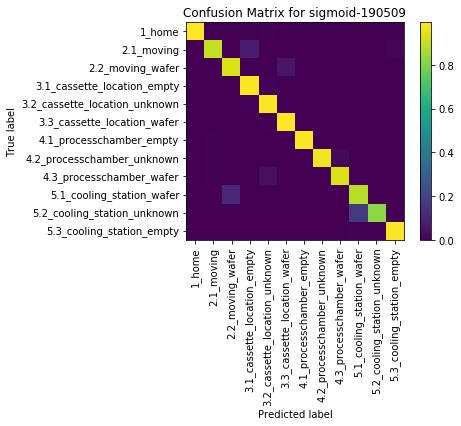

confusion matrix saved to ./output/ml\sigmoid-190509.svg


In [6]:
np.set_printoptions(precision=3, threshold=1000, linewidth=180, nanstr="n", suppress=True)

# generate confusion matrix and normalize
confusion = confusion_matrix(confusion_labels, confusion_predictions)
pprint(confusion)
confusion = np.ma.array(confusion, mask=np.isnan(confusion))
confusion = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]

# use all labels to allow for comparison
confusion_classes = [label_name[i][1] for i in label_name]

# discard columns from confusion matrix that are not known by model
index = 0
confusion_model_labels = []
confusion_model_columns = []
for label in label_name:
    if label not in model_labels:
        print("Label {} with index {} is not known to model. Dropping...".format(label_name[label], index))
    else:
        confusion_model_columns.append(index)
        confusion_model_labels.append(model_labels[label][1])
    index += 1
confusion = confusion[:,confusion_model_columns]
        
# setup plot
fig, ax = plt.subplots()
im = ax.imshow(confusion, interpolation='nearest')
ax.figure.colorbar(im, ax=ax)
ax.set(
    xticks=np.arange(confusion.shape[1]),
    yticks=np.arange(confusion.shape[0]),
    xticklabels=confusion_model_labels, yticklabels=confusion_classes,
    title="Confusion Matrix for {}".format(config_modelname),
    ylabel='True label',
    xlabel='Predicted label'
)
plt.setp(ax.get_yticklabels(), rotation_mode="anchor", ha="right", va="center")
plt.setp(ax.get_xticklabels(), rotation=90, rotation_mode="anchor", ha="right", va="center")

# save and show
svg_path = os.path.join(config["outputfolder"], "{}.svg".format(config_modelname))
plt.savefig(svg_path, format="svg", bbox_inches='tight')
plt.show()
print("confusion matrix saved to {}".format(svg_path))

In [7]:
if out is not None:
    out.release()
cv.destroyAllWindows()

In [9]:
# https://stackoverflow.com/questions/37657547/how-to-save-jupyter-notebook-to-html-by-code
from IPython.display import Javascript

def save_notebook():
    return display(Javascript("IPython.notebook.save_notebook()"), include=['application/javascript'])

def output_HTML(read_file, output_file):
    from nbconvert import HTMLExporter
    import nbformat
    import codecs
    
    html_exporter = HTMLExporter()
    notebook = nbformat.read(read_file, as_version=4)
    body, resources = html_exporter.from_notebook_node(notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(body)
    
import time
save_notebook()
time.sleep(3)
current_file = "eval.ipynb"
output_file = os.path.join(config["outputfolder"], "{}.html".format(config_modelname))
output_HTML(current_file, output_file)

[0.0001 0.0000 0.0000 0.0007 0.0000 0.0000 0.9983 0.0004 0.0000 0.0000 0.0004 0.0000] unknown (-1<>6)


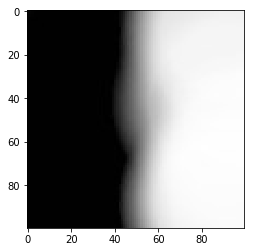

In [10]:
img = cv.imread(r"input\d.jpg", cv.IMREAD_GRAYSCALE)
mean, dev = cv.meanStdDev(img)
img_small = cv.resize((img - mean)/dev, (100,100))
img_small = np.expand_dims(img_small, axis=2)
img_small = np.expand_dims(img_small, axis=0)

predictions = model.predict(img_small)
predicted = np.argmax(predictions)
res = pprint_result(predictions[0], -1)

img = cv.cvtColor(img, cv.COLOR_GRAY2RGB)
plt.imshow(img); plt.show()
